# 精神病に関するアンケート結果の解析

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model as lm
from sklearn.metrics import confusion_matrix

## データ概観

In [2]:
df_raw = pd.read_csv('./survey.csv')
pandas_profiling.ProfileReport(df_raw)

Number of variables,27
Number of observations,1259
Total Missing (%),5.6%
Total size in memory,265.6 KiB
Average record size in memory,216.1 B
Numeric,1
Categorical,26
Boolean,0
Date,0
Text (Unique),0
Rejected,0


一見して以下の事がわかる。
- Ageに外れ値がある
- Genderの名寄せが必要
- work_interfere、commentsは無効値が多い
- アメリカ合衆国以外の(stateの記載がない)回答が約40%

## 方針
##### treatment（精神病の治療を受けたことがあるか）を目的変数とする
1. 年齢が外れ値の項目を削除
1. 性別を名寄せ
1. 雇用形態の回答の無効値を削除
1. 今回は簡単のため、扱いずらい項目は思い切って削除する
1. 各項目とtreatmentの関係を目視し、説明変数を決定する

In [3]:
df = df_raw.copy()

#### 年齢が異常値（0歳以下、120歳以上）のデータを削除

In [4]:
# 年齢が異常値の行を削除
drop_list = []
for index, row in df.iterrows():
    if int(row['Age']) < 0 or int(row['Age']) > 120:
        drop_list.append(index)
df.drop(drop_list, inplace=True)

#### 性別の名寄せ（男性、女性、その他）

In [5]:
df.loc[df['Gender'].str.lower().str.contains('^(cis)*.*(female|woman|f|femail).?$'), 'Gender'] = 'F'
df.loc[df['Gender'].str.lower().str.contains('^female \(cis\)$'), 'Gender'] = 'F'
df.loc[df['Gender'].str.lower().str.contains('^(cis)*.*(male|man|m|make|mail).?$'), 'Gender'] = 'M'
df.loc[df['Gender'].str.lower().str.contains('^(male \(cis\)|mal)$'), 'Gender'] = 'M'
df.loc[~df['Gender'].str.contains('(^(F|M)$)'),'Gender'] = 'other'

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


#### 無効値を"no_data"で置き換え

In [6]:
df.fillna({'self_employed':'no_data', 'state':'no_data', 'work_interfere':'no_data'}, inplace=True)

#### その他
- 回答日時を年のみに変更
- コメントありの場合、"existence"とする
- アメリカ以外の国の場合は州を"no_data"にする

In [7]:
df.replace('-[0-9]+-[0-9]+ .*', '', regex=True, inplace=True)
df.fillna({'comments':'none'}, inplace=True)
df.loc[df['comments'] != 'none', 'comments'] = 'existence'
df.loc[df['Country'] != 'United States', 'state'] = 'no_data'

## treatment との関係を確認

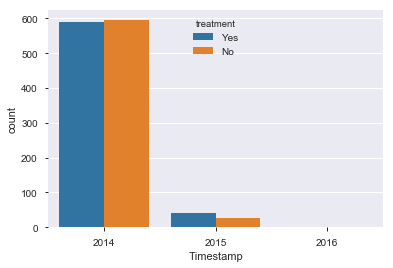

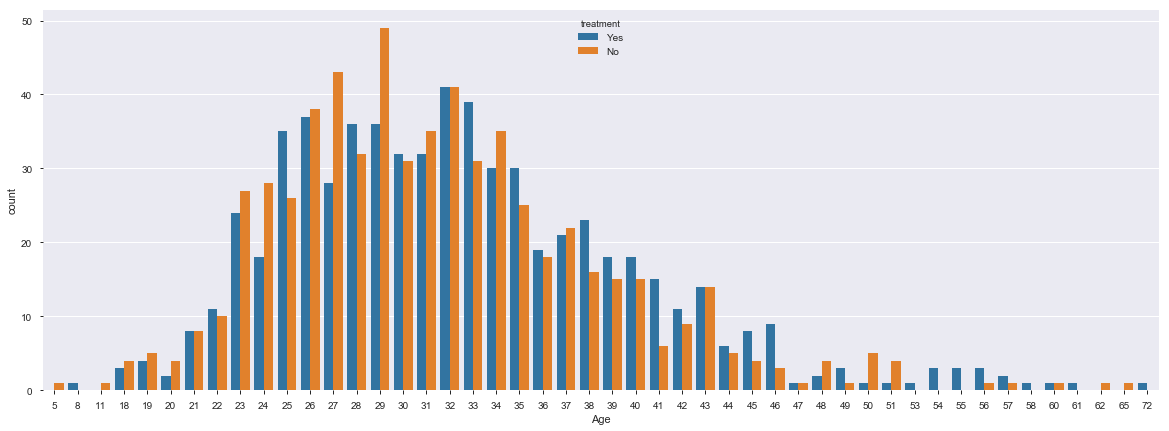

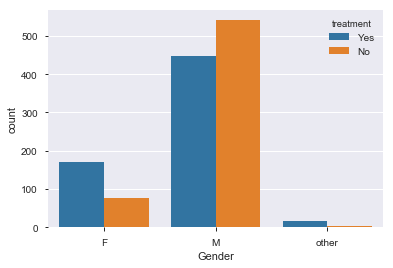

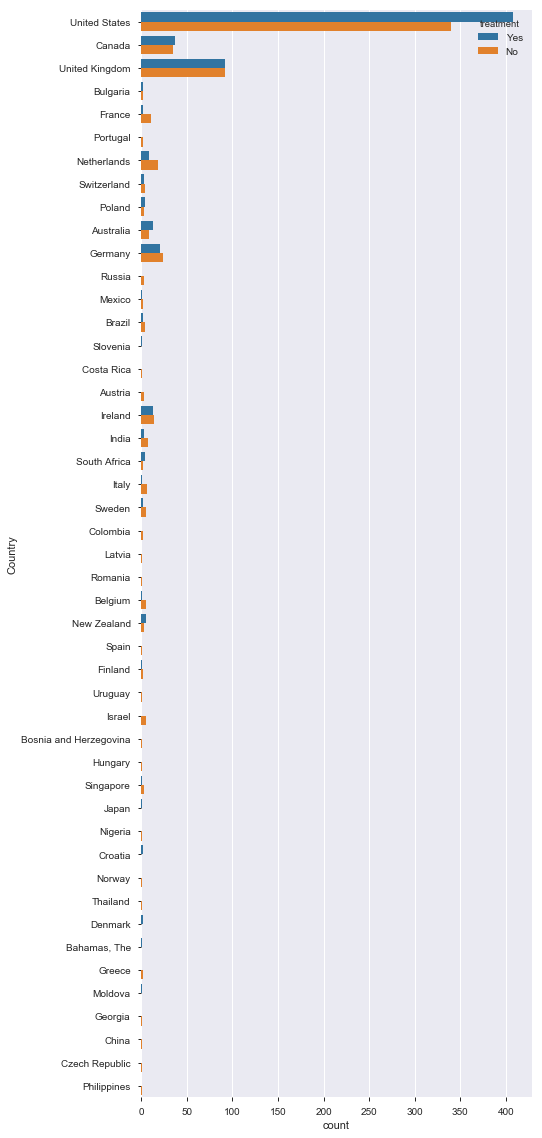

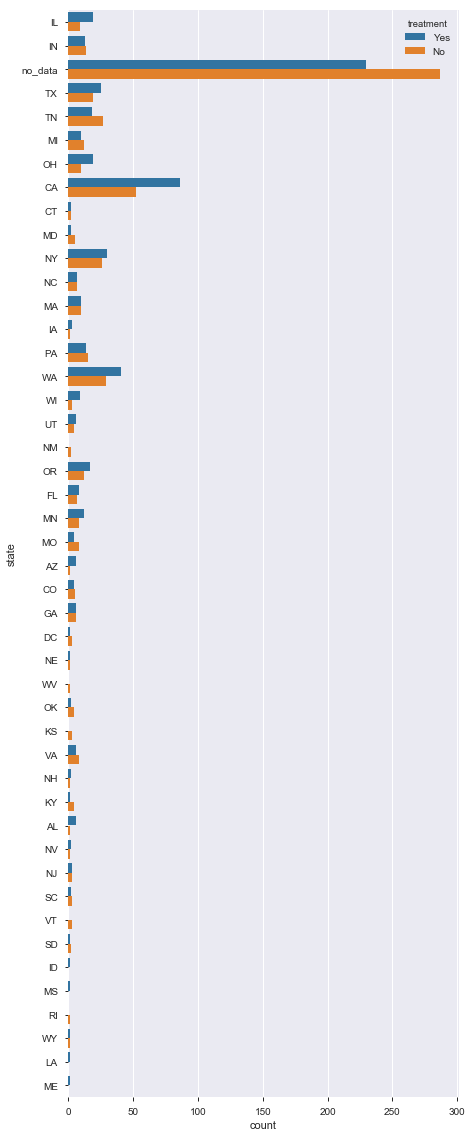

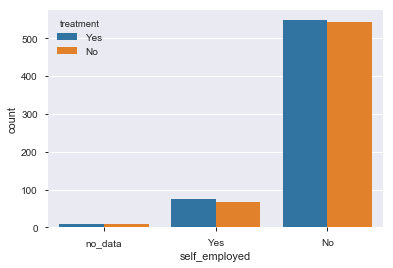

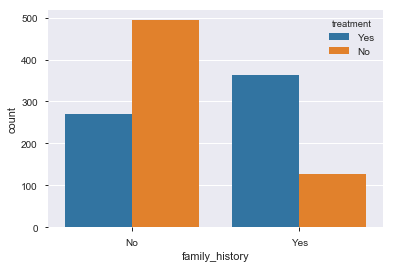

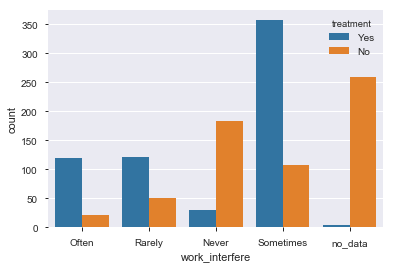

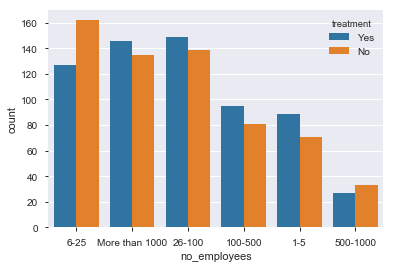

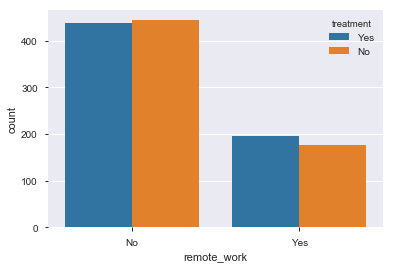

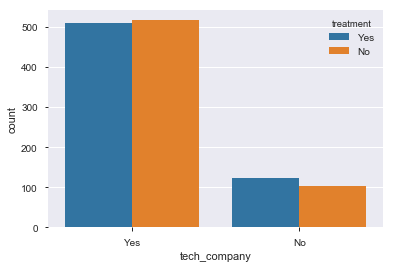

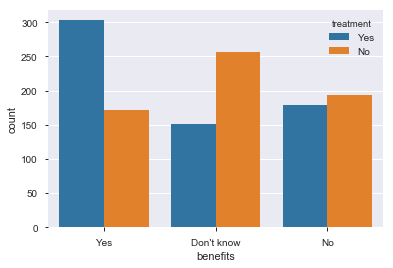

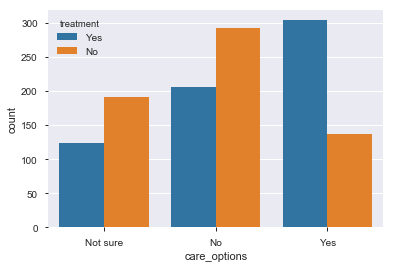

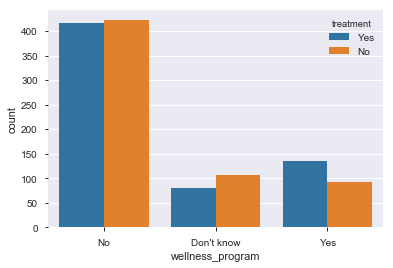

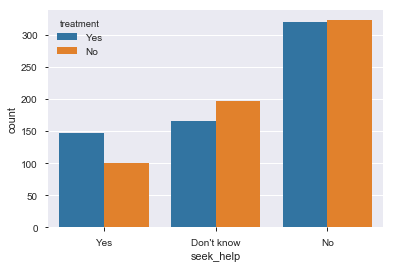

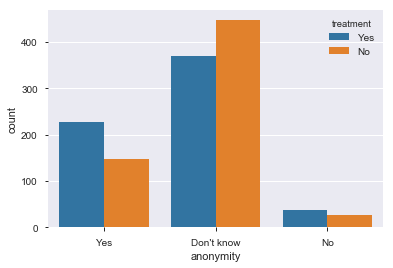

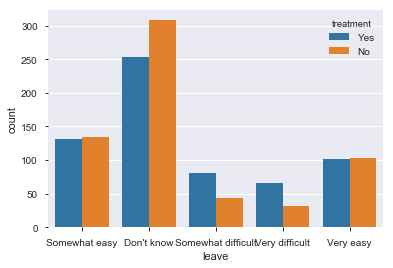

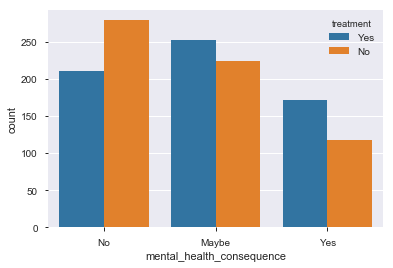

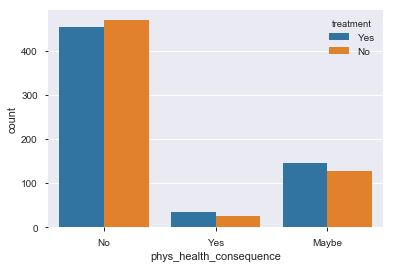

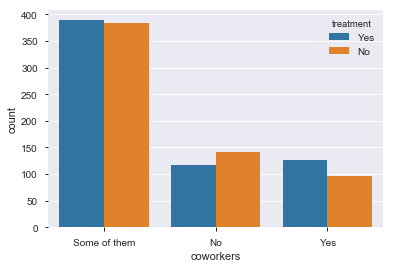

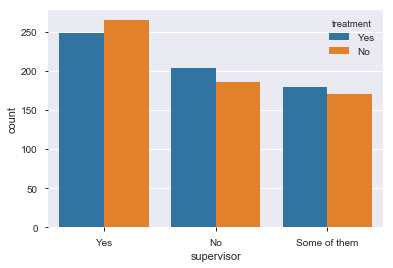

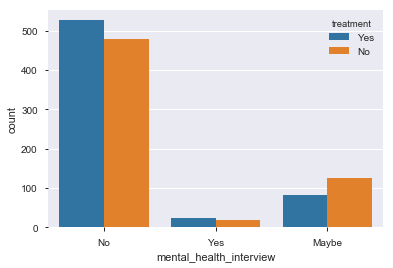

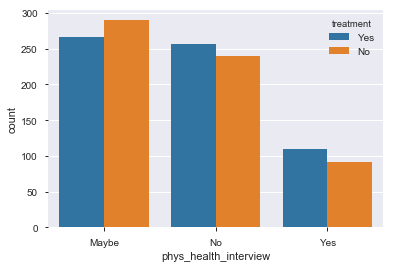

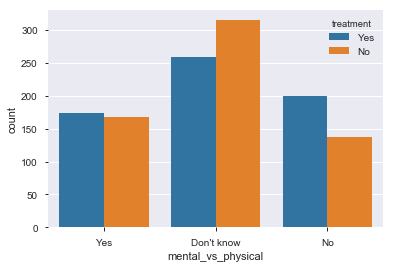

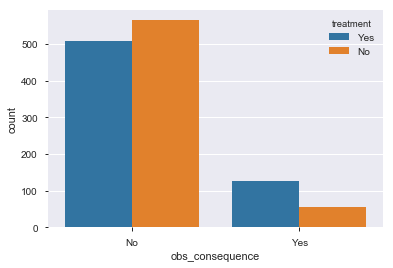

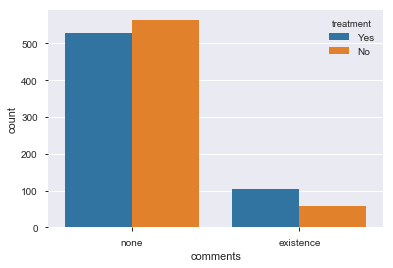

In [8]:
%matplotlib inline
    
for col in df.columns:
#     if col not in check_list:
#         continue
    if col == 'treatment':
        continue
    if col == 'Country' or col == 'state':
        plt.figure(figsize=(7, 20))
        sns.countplot(y=col, hue='treatment', hue_order=df['treatment'].unique(), data=df)
    else:
        if col == 'Age':
            plt.figure(figsize=(20, 7))
        sns.countplot(x=col, hue='treatment', hue_order=df['treatment'].unique(), data=df)
    plt.show()   

## モデル作成準備
### 学習データ分割
精度比較のため、"train_test_split"のランダム変数の種を0固定

In [9]:
def make_dataset(df_exp, df_res, test_ratio):
    bi_list = []
    for column in df_exp.columns: 
        if df_exp[column].nunique() < 3:
            bi_list.append(column)
    for c in bi_list:
        col = df_exp.columns.tolist()
        col.remove(c)
        col.append(c)
        df_exp_proc = df_exp.ix[:,col]

    df_exp_proc = pd.get_dummies(df_exp_proc)
    df_res_proc = pd.get_dummies(df_res)

    x = df_exp_proc#.as_matrix
    y = df_res_proc['Yes']#.as_matrix
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
#     print(y_test[:10])
    return X_train, X_test, y_train, y_test

### 認識器設定

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras import optimizers

def NN(X_train, X_test, y_train, y_test):
    y_train_ = []
    for tmp in y_train:
        if tmp == 1:
            y_train_.append([0, 1])
        else:
            y_train_.append([1, 0])
    y_train = pd.DataFrame(y_train_)
    y_test_ = []
    for tmp in y_test:
        if tmp == 1:
            y_test_.append([0, 1])
        else:
            y_test_.append([1, 0])
    y_test = pd.DataFrame(y_test_)

    model = Sequential([
        Dense(50, input_shape=(len(X_train.columns),)),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(2),
        Activation('softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=100, validation_split=0.1)
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Test Accuracy = ', score[1])
    return score[1]

Using TensorFlow backend.


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm

def classifiers(X_train, X_test, y_train, y_test, cv_num=5):

    results = {'ロジスティック回帰': 0, '決定木': 0,  'バギング': 0, 
                'ランダムフォレスト': 0, 'アダブースト': 0, 
                'K近傍法': 0, 'SVM': 0}


    print('ニューラルネット')
    results['ニューラルネット'] = NN(X_train, X_test, y_train, y_test)
    
    # ロジスティック回帰
    print('ロジスティック回帰')
    clf = lm.LogisticRegression()
    clf.fit (X_train, y_train)
    y_pred_clf = clf.predict(X_test)
    max_acc = 0
    max_thr = 0
    y_test_value = y_test.values
    for i in range(1, 10, 1):
        thr = i * 0.1
        y_pred_clf = clf.predict(X_test)
        y_pred_clf[y_pred_clf < thr] = 0
        y_pred_clf[y_pred_clf >= thr] = 1
        cm = confusion_matrix(y_test_value, y_pred_clf)
        acc = (cm[0][0]+cm[1][1]) / (np.array(cm).sum())
        if acc > max_acc:
            max_acc = acc
            max_thr = i * 0.1
    print('Threshold : ', end='')
    print(max_thr)
    y_pred_clf[y_pred_clf < max_thr] = 0
    y_pred_clf[y_pred_clf >= max_thr] = 1
    y_test_value = y_test.values
    cm = confusion_matrix(y_test_value, y_pred_clf)
#     print('Confusion Matrix : ')
#     print(cm)
    print('Accuracy = ', end='')
    print((cm[0][0]+cm[1][1]) / (np.array(cm).sum()))
#     print('Recall of Yes = ', end='')
#     print(cm[1][1] / (cm[1][0]+cm[1][1]))
#     print('Precision of Yes = ', end='')
#     print(cm[1][1] / (cm[0][1]+cm[1][1]))
    results['ロジスティック回帰'] = (cm[0][0]+cm[1][1]) / (np.array(cm).sum())
    print('')
    
    print('決定木')
    tuned_parameters = [{'max_depth':[5,10, 20, 30], 'max_features':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_tree = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_tree.fit(X_train, y_train) 
    result_best = clf_gs_cv_tree.best_params_
    print('Train Accuracy =', clf_gs_cv_tree.best_score_, clf_gs_cv_tree.best_params_)
    predicted_labels = clf_gs_cv_tree.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['決定木'] = score
    print('')

    print('バギング')
#     tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'max_features':[0.4, 0.6, 0.8, 1.0], 'max_samples':[0.4, 0.6, 0.8, 1.0]}]
    tuned_parameters = [{'n_estimators':[30, 50, 80, 100], 'max_features':[0.4, 0.6, 1.0], 'max_samples':[0.4, 0.8, 1.0]}]
    clf_gs_cv_bagging = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_bagging.fit(X_train, y_train) 
    result_best = clf_gs_cv_bagging.best_params_
    print('Train Accuracy =', clf_gs_cv_bagging.best_score_, clf_gs_cv_bagging.best_params_)
    predicted_labels = clf_gs_cv_bagging.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['バギング'] = score
    print('')

    print('ランダムフォレスト')
    tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'max_features':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_rand = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_rand.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_rand.best_score_, clf_gs_cv_rand.best_params_)
    predicted_labels = clf_gs_cv_rand.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['ランダムフォレスト'] = score
    print('')

    print('アダブースト')
    tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'learning_rate':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm='SAMME.R', random_state=None), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_ada.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_ada.best_score_, clf_gs_cv_ada.best_params_)
    predicted_labels = clf_gs_cv_ada.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['アダブースト'] = score
    print('')

    print('K近傍法')
    tuned_parameters = [{'n_neighbors':[1, 3, 5, 8, 10, 12]}]
    clf_gs_cv_kn = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_kn.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_kn.best_score_, clf_gs_cv_kn.best_params_)
    predicted_labels = clf_gs_cv_kn.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['K近傍法'] = score
    print('')
    
    print('SVM')
    tuned_parameters = [{'C':[0.4, 0.8, 1.0, 1.2, 1.4, 1.8, 2.0]}]
    clf_gs_cv_svm = GridSearchCV(svm.SVC(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_svm.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_svm.best_score_, clf_gs_cv_svm.best_params_)
    predicted_labels = clf_gs_cv_svm.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['SVM'] = score
    print('')
    
    print('ランダムフォレストにおける各項目の影響度')
    clf_rand = RandomForestClassifier(n_estimators = clf_gs_cv_rand.best_params_['n_estimators'], \
                                      random_state = None, max_features = clf_gs_cv_rand.best_params_['max_features'])
    clf_rand.fit(X_train, y_train)
    predicted_labels = clf_rand.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Score: ', score)
    import matplotlib.pyplot as plt
    %matplotlib inline
    features = X_train.columns
    importances = clf_rand.feature_importances_
    indices = np.argsort(importances)
    if len(indices) > 20:
        indices = indices[len(indices)-20:]
    plt.figure(figsize=(6,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.show()

    return results

In [12]:
results = {}

## 認識器作成

### 元データ

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ニューラルネット
377/377 [==============================] - 0s 147us/step
Test Accuracy =  0.6816976146293255
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.8010610079575596

決定木
Train Accuracy = 0.830102622576967 {'max_depth': 5, 'max_features': 0.8}
Test Accuracy: 0.7824933687002652

バギング
Train Accuracy = 0.8483466362599772 {'max_samples': 0.4, 'max_features': 1.0, 'n_estimators': 100}
Test Accuracy: 0.7931034482758621

ランダムフォレスト
Train Accuracy = 0.8392246294184721 {'max_features': 0.4, 'n_estimators': 100}
Test Accuracy: 0.7904509283819628

アダブースト
Train Accuracy = 0.7730900798175598 {'learning_rate': 0.4, 'n_estimators': 80}
Test Accuracy: 0.7320954907161804

K近傍法
Train Accuracy = 0.6955530216647663 {'n_neighbors': 5}
Test Accuracy: 0.6684350132625995

SVM
Train Accuracy = 0.8403648802736602 {'C': 1.8}
Test Accuracy: 0.7877984084880637

ランダムフォレストにおける各項目の影響度
Score:  0.7957559681697612


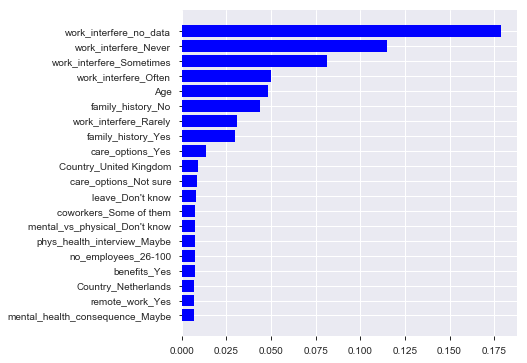

In [13]:
df_exp = df.drop(['treatment'], axis=1)
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['元データ'] = classifiers(X_train, X_test, y_train, y_test, 5)

ランダムフォレストでの影響度を見ると、work_inference、family_history、Ageの有効性が比較的大きいことがわかる。

### ３項目抽出
work_inference、family_history、Ageのみで認識器を作成する。

ニューラルネット


C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


377/377 [==============================] - 0s 53us/step
Test Accuracy =  0.7135278522493985
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.7931034482758621

決定木
Train Accuracy = 0.8335233751425314 {'max_depth': 5, 'max_features': 0.8}
Test Accuracy: 0.7957559681697612

バギング
Train Accuracy = 0.8415051311288484 {'max_samples': 0.4, 'max_features': 0.6, 'n_estimators': 50}
Test Accuracy: 0.7824933687002652

ランダムフォレスト
Train Accuracy = 0.8118586088939567 {'max_features': 0.8, 'n_estimators': 100}
Test Accuracy: 0.7798408488063661

アダブースト
Train Accuracy = 0.8084378563283923 {'learning_rate': 0.4, 'n_estimators': 80}
Test Accuracy: 0.7639257294429708

K近傍法
Train Accuracy = 0.7765108323831242 {'n_neighbors': 12}
Test Accuracy: 0.7427055702917772

SVM
Train Accuracy = 0.8380843785632839 {'C': 2.0}
Test Accuracy: 0.7931034482758621

ランダムフォレストにおける各項目の影響度
Score:  0.7798408488063661


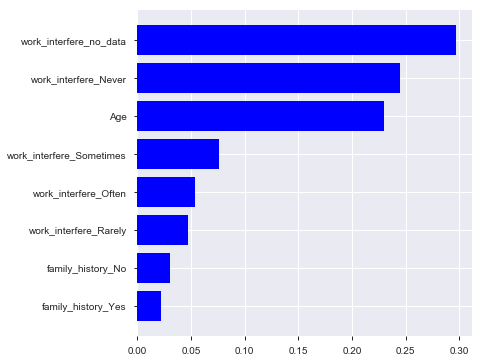

In [14]:
df_exp = df.loc[:,['work_interfere', 'family_history', 'Age']]
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['３項目抽出'] = classifiers(X_train, X_test, y_train, y_test, 5)

ほとんど変わらず。ほかの項目の有無はランダムフォレスト以外の認識器でも影響が小さいということか。

### 従業員数を数値化
今は従業員数がカテゴリ変数になっているが、大小関係や比率が有効かもしれないと考え、数値化した。
数値は1000未満は真ん中の値、1000より多いものは仮に1500とした。

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ニューラルネット
377/377 [==============================] - 0s 96us/step
Test Accuracy =  0.5013262603422058
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.8090185676392573

決定木
Train Accuracy = 0.830102622576967 {'max_depth': 5, 'max_features': 0.6}
Test Accuracy: 0.8063660477453581

バギング
Train Accuracy = 0.8517673888255416 {'max_samples': 0.4, 'max_features': 1.0, 'n_estimators': 50}
Test Accuracy: 0.7984084880636605

ランダムフォレスト
Train Accuracy = 0.8415051311288484 {'max_features': 0.4, 'n_estimators': 80}
Test Accuracy: 0.7931034482758621

アダブースト
Train Accuracy = 0.7594070695553021 {'learning_rate': 0.6, 'n_estimators': 80}
Test Accuracy: 0.713527851458886

K近傍法
Train Accuracy = 0.645381984036488 {'n_neighbors': 5}
Test Accuracy: 0.6790450928381963

SVM
Train Accuracy = 0.7251995438996579 {'C': 2.0}
Test Accuracy: 0.7347480106100795

ランダムフォレストにおける各項目の影響度
Score:  0.7957559681697612


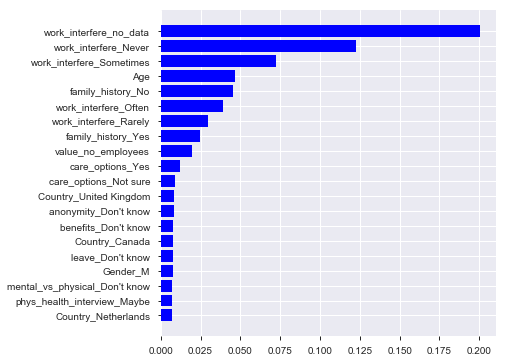

In [15]:
#従業員数を量的データに変換
df_proc = df.copy()
df_proc['value_no_employees'] = 0
df_proc.loc[df_proc['no_employees'] == '1-5', 'value_no_employees'] = 3
df_proc.loc[df_proc['no_employees'] == '6-25', 'value_no_employees'] = 16
df_proc.loc[df_proc['no_employees'] == '26-100', 'value_no_employees'] = 63
df_proc.loc[df_proc['no_employees'] == '100-500', 'value_no_employees'] = 300
df_proc.loc[df_proc['no_employees'] == '500-1000', 'value_no_employees'] = 750
df_proc.loc[df_proc['no_employees'] == 'More than 1000', 'value_no_employees'] = 1500
df_exp = df_proc.drop(['treatment', 'no_employees'], axis=1)
df_res = df_proc['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['従業員数を数値化'] = classifiers(X_train, X_test, y_train, y_test, 5)

精度が悪化した。ランダムフォレストの重要度をみると、従業員数が上位に来ているので、影響度は上がったようだが、逆効果か。

## 結果
各データセット、各認識器でのTest Accuracyを下表に示す。

In [16]:
index_ = []
cols = [[],[],[],[],[],[],[],[]]
for key in results.keys():
    index_.append(key)
    for i, method in enumerate(results[key].keys()):
        cols[i].append(results[key][method])
df_results = pd.DataFrame({},index=index_)
for i, method in enumerate(results['元データ'].keys()):
    df_results[method] = cols[i]
df_results

,ランダムフォレスト,K近傍法,ロジスティック回帰,決定木,アダブースト,ニューラルネット,バギング,SVM
３項目抽出,0.779841,0.742706,0.793103,0.795756,0.763926,0.713528,0.782493,0.793103
従業員数を数値化,0.793103,0.679045,0.809019,0.806366,0.713528,0.501326,0.798408,0.734748
元データ,0.790451,0.668435,0.801061,0.782493,0.732095,0.681698,0.793103,0.787798


どれも80%弱の精度が出ているが、データセット調整および手法の違いによって精度を向上できなかった。  
特に、ロジスティック回帰が比較的優位な精度を出している点が不可解である。
NNについてハイパーパラメータを調べていないので、以下試しに実行する。

In [19]:
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
y_train_ = []
for tmp in y_train:
    if tmp == 1:
        y_train_.append([0, 1])
    else:
        y_train_.append([1, 0])
y_train = pd.DataFrame(y_train_)
y_test_ = []
for tmp in y_test:
    if tmp == 1:
        y_test_.append([0, 1])
    else:
        y_test_.append([1, 0])
y_test = pd.DataFrame(y_test_)

model = Sequential([
    Dense(500, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(300),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=100, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


377/377 [==============================] - 0s 169us/step
Test Accuracy =  0.655172414267411


In [20]:

X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
y_train_ = []
for tmp in y_train:
    if tmp == 1:
        y_train_.append([0, 1])
    else:
        y_train_.append([1, 0])
y_train = pd.DataFrame(y_train_)
y_test_ = []
for tmp in y_test:
    if tmp == 1:
        y_test_.append([0, 1])
    else:
        y_test_.append([1, 0])
y_test = pd.DataFrame(y_test_)

model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=20, verbose=1, epochs=200, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Train on 789 samples, validate on 88 samples
Epoch 1/200
789/789 [==============================] - 0s 500us/step - loss: 0.7027 - acc: 0.5234 - val_loss: 0.6861 - val_acc: 0.6023
Epoch 2/200
789/789 [==============================] - 0s 222us/step - loss: 0.6837 - acc: 0.5412 - val_loss: 0.6796 - val_acc: 0.5682
Epoch 3/200
789/789 [==============================] - 0s 276us/step - loss: 0.6778 - acc: 0.5678 - val_loss: 0.6759 - val_acc: 0.5568
Epoch 4/200
789/789 [==============================] - 0s 210us/step - loss: 0.6727 - acc: 0.5932 - val_loss: 0.6750 - val_acc: 0.5682
Epoch 5/200
789/789 [==============================] - 0s 328us/step - loss: 0.6700 - acc: 0.5843 - val_loss: 0.6734 - val_acc: 0.5341
Epoch 6/200
789/789 [==============================] - 0s 437us/step - loss: 0.6647 - acc: 0.6020 - val_loss: 0.6666 - val_acc: 0.6023
Epoch 7/200
789/789 [==============================] - 0s 335us/step - loss: 0.6626 - acc: 0.6236 - val_loss: 0.6602 - val_acc: 0.6364
Epoch 8/20

Epoch 61/200
789/789 [==============================] - 0s 233us/step - loss: 0.5647 - acc: 0.7465 - val_loss: 0.5922 - val_acc: 0.6364
Epoch 62/200
789/789 [==============================] - 0s 343us/step - loss: 0.5621 - acc: 0.7452 - val_loss: 0.5828 - val_acc: 0.6932
Epoch 63/200
789/789 [==============================] - 0s 219us/step - loss: 0.5631 - acc: 0.7452 - val_loss: 0.5829 - val_acc: 0.6932
Epoch 64/200
789/789 [==============================] - 0s 362us/step - loss: 0.5592 - acc: 0.7490 - val_loss: 0.5831 - val_acc: 0.6932
Epoch 65/200
789/789 [==============================] - 0s 185us/step - loss: 0.5589 - acc: 0.7427 - val_loss: 0.5789 - val_acc: 0.7273
Epoch 66/200
789/789 [==============================] - 0s 339us/step - loss: 0.5574 - acc: 0.7427 - val_loss: 0.5779 - val_acc: 0.7273
Epoch 67/200
789/789 [==============================] - 0s 284us/step - loss: 0.5567 - acc: 0.7503 - val_loss: 0.5771 - val_acc: 0.6932
Epoch 68/200
789/789 [==========================

789/789 [==============================] - 0s 206us/step - loss: 0.4871 - acc: 0.7807 - val_loss: 0.5222 - val_acc: 0.7045
Epoch 122/200
789/789 [==============================] - 0s 195us/step - loss: 0.4850 - acc: 0.7883 - val_loss: 0.5284 - val_acc: 0.7045
Epoch 123/200
789/789 [==============================] - 0s 203us/step - loss: 0.4820 - acc: 0.7883 - val_loss: 0.5201 - val_acc: 0.7045
Epoch 124/200
789/789 [==============================] - 0s 211us/step - loss: 0.4816 - acc: 0.7782 - val_loss: 0.5179 - val_acc: 0.7045
Epoch 125/200
789/789 [==============================] - 0s 216us/step - loss: 0.4823 - acc: 0.7820 - val_loss: 0.5159 - val_acc: 0.7159
Epoch 126/200
789/789 [==============================] - 0s 213us/step - loss: 0.4804 - acc: 0.7871 - val_loss: 0.5149 - val_acc: 0.7159
Epoch 127/200
789/789 [==============================] - 0s 199us/step - loss: 0.4780 - acc: 0.7845 - val_loss: 0.5157 - val_acc: 0.7614
Epoch 128/200
789/789 [==============================] 

Epoch 181/200
789/789 [==============================] - 0s 370us/step - loss: 0.4296 - acc: 0.8150 - val_loss: 0.4720 - val_acc: 0.7386
Epoch 182/200
789/789 [==============================] - 0s 305us/step - loss: 0.4288 - acc: 0.8099 - val_loss: 0.4740 - val_acc: 0.7727
Epoch 183/200
789/789 [==============================] - 0s 225us/step - loss: 0.4278 - acc: 0.8188 - val_loss: 0.4698 - val_acc: 0.7386
Epoch 184/200
789/789 [==============================] - 0s 324us/step - loss: 0.4256 - acc: 0.8099 - val_loss: 0.4732 - val_acc: 0.7727
Epoch 185/200
789/789 [==============================] - 0s 397us/step - loss: 0.4272 - acc: 0.8188 - val_loss: 0.4699 - val_acc: 0.7500
Epoch 186/200
789/789 [==============================] - 0s 327us/step - loss: 0.4267 - acc: 0.8200 - val_loss: 0.4686 - val_acc: 0.7386
Epoch 187/200
789/789 [==============================] - 0s 229us/step - loss: 0.4268 - acc: 0.8099 - val_loss: 0.4687 - val_acc: 0.7614
Epoch 188/200
789/789 [==================

In [21]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.01, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=200, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

Train on 789 samples, validate on 88 samples
Epoch 1/200
789/789 [==============================] - 0s 452us/step - loss: 0.6983 - acc: 0.5437 - val_loss: 0.7094 - val_acc: 0.4886
Epoch 2/200
789/789 [==============================] - 0s 118us/step - loss: 0.6841 - acc: 0.5437 - val_loss: 0.6631 - val_acc: 0.5795
Epoch 3/200
789/789 [==============================] - 0s 110us/step - loss: 0.6691 - acc: 0.5881 - val_loss: 0.6476 - val_acc: 0.6364
Epoch 4/200
789/789 [==============================] - 0s 112us/step - loss: 0.6528 - acc: 0.6375 - val_loss: 0.6588 - val_acc: 0.6023
Epoch 5/200
789/789 [==============================] - 0s 104us/step - loss: 0.6517 - acc: 0.6248 - val_loss: 0.6476 - val_acc: 0.6023
Epoch 6/200
789/789 [==============================] - 0s 103us/step - loss: 0.6403 - acc: 0.6439 - val_loss: 0.6395 - val_acc: 0.6932
Epoch 7/200
789/789 [==============================] - 0s 114us/step - loss: 0.6325 - acc: 0.6781 - val_loss: 0.6479 - val_acc: 0.6023
Epoch 8/20

789/789 [==============================] - 0s 102us/step - loss: 0.4482 - acc: 0.7845 - val_loss: 0.4390 - val_acc: 0.8182
Epoch 62/200
789/789 [==============================] - 0s 107us/step - loss: 0.4208 - acc: 0.8162 - val_loss: 0.4495 - val_acc: 0.8182
Epoch 63/200
789/789 [==============================] - 0s 109us/step - loss: 0.4442 - acc: 0.7985 - val_loss: 0.4551 - val_acc: 0.7955
Epoch 64/200
789/789 [==============================] - 0s 70us/step - loss: 0.4308 - acc: 0.8099 - val_loss: 0.4397 - val_acc: 0.7841
Epoch 65/200
789/789 [==============================] - 0s 75us/step - loss: 0.4549 - acc: 0.7858 - val_loss: 0.4328 - val_acc: 0.8068
Epoch 66/200
789/789 [==============================] - 0s 85us/step - loss: 0.4242 - acc: 0.8086 - val_loss: 0.4729 - val_acc: 0.7841
Epoch 67/200
789/789 [==============================] - 0s 80us/step - loss: 0.4200 - acc: 0.8112 - val_loss: 0.5724 - val_acc: 0.7273
Epoch 68/200
789/789 [==============================] - 0s 133us/

789/789 [==============================] - 0s 81us/step - loss: 0.4135 - acc: 0.8175 - val_loss: 0.4332 - val_acc: 0.8295
Epoch 122/200
789/789 [==============================] - 0s 85us/step - loss: 0.3688 - acc: 0.8441 - val_loss: 0.4320 - val_acc: 0.8295
Epoch 123/200
789/789 [==============================] - 0s 155us/step - loss: 0.3801 - acc: 0.8264 - val_loss: 0.4741 - val_acc: 0.7614
Epoch 124/200
789/789 [==============================] - 0s 143us/step - loss: 0.3783 - acc: 0.8327 - val_loss: 0.4071 - val_acc: 0.8523
Epoch 125/200
789/789 [==============================] - 0s 93us/step - loss: 0.3681 - acc: 0.8454 - val_loss: 0.4245 - val_acc: 0.8295
Epoch 126/200
789/789 [==============================] - 0s 79us/step - loss: 0.3928 - acc: 0.8302 - val_loss: 0.5622 - val_acc: 0.7841
Epoch 127/200
789/789 [==============================] - 0s 111us/step - loss: 0.3605 - acc: 0.8492 - val_loss: 0.4570 - val_acc: 0.7614
Epoch 128/200
789/789 [==============================] - 0s

789/789 [==============================] - 0s 61us/step - loss: 0.3824 - acc: 0.8428 - val_loss: 0.4104 - val_acc: 0.8295
Epoch 182/200
789/789 [==============================] - 0s 83us/step - loss: 0.3484 - acc: 0.8619 - val_loss: 0.4242 - val_acc: 0.8295
Epoch 183/200
789/789 [==============================] - 0s 84us/step - loss: 0.3427 - acc: 0.8593 - val_loss: 0.7782 - val_acc: 0.6477
Epoch 184/200
789/789 [==============================] - 0s 140us/step - loss: 0.3843 - acc: 0.8390 - val_loss: 0.4235 - val_acc: 0.8295
Epoch 185/200
789/789 [==============================] - 0s 80us/step - loss: 0.3712 - acc: 0.8454 - val_loss: 0.4081 - val_acc: 0.8295
Epoch 186/200
789/789 [==============================] - 0s 55us/step - loss: 0.3443 - acc: 0.8504 - val_loss: 0.3938 - val_acc: 0.8295
Epoch 187/200
789/789 [==============================] - 0s 159us/step - loss: 0.3645 - acc: 0.8428 - val_loss: 0.4137 - val_acc: 0.8295
Epoch 188/200
789/789 [==============================] - 0s 

In [22]:
model = Sequential([
    Dense(500, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(400),
    Activation('relu'),
    Dense(300),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.01, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=200, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

Train on 789 samples, validate on 88 samples
Epoch 1/200
789/789 [==============================] - 0s 526us/step - loss: 0.8252 - acc: 0.5184 - val_loss: 0.6826 - val_acc: 0.6250
Epoch 2/200
789/789 [==============================] - 0s 122us/step - loss: 0.6836 - acc: 0.5653 - val_loss: 0.6704 - val_acc: 0.6591
Epoch 3/200
789/789 [==============================] - 0s 103us/step - loss: 0.6725 - acc: 0.6109 - val_loss: 0.6568 - val_acc: 0.5568
Epoch 4/200
789/789 [==============================] - 0s 110us/step - loss: 0.6565 - acc: 0.6324 - val_loss: 0.6535 - val_acc: 0.5682
Epoch 5/200
789/789 [==============================] - 0s 109us/step - loss: 0.6452 - acc: 0.6439 - val_loss: 0.6477 - val_acc: 0.6932
Epoch 6/200
789/789 [==============================] - 0s 102us/step - loss: 0.6460 - acc: 0.6793 - val_loss: 0.6389 - val_acc: 0.6932
Epoch 7/200
789/789 [==============================] - 0s 180us/step - loss: 0.6383 - acc: 0.6375 - val_loss: 0.6302 - val_acc: 0.6705
Epoch 8/20

789/789 [==============================] - 0s 193us/step - loss: 0.4227 - acc: 0.8162 - val_loss: 0.5026 - val_acc: 0.7727
Epoch 62/200
789/789 [==============================] - 0s 145us/step - loss: 0.4109 - acc: 0.8200 - val_loss: 0.4330 - val_acc: 0.8068
Epoch 63/200
789/789 [==============================] - 0s 127us/step - loss: 0.3986 - acc: 0.8314 - val_loss: 0.4481 - val_acc: 0.7841
Epoch 64/200
789/789 [==============================] - 0s 93us/step - loss: 0.4019 - acc: 0.8314 - val_loss: 0.4459 - val_acc: 0.7841
Epoch 65/200
789/789 [==============================] - 0s 148us/step - loss: 0.4149 - acc: 0.8150 - val_loss: 0.4377 - val_acc: 0.8182
Epoch 66/200
789/789 [==============================] - 0s 147us/step - loss: 0.4127 - acc: 0.8188 - val_loss: 0.4363 - val_acc: 0.8295
Epoch 67/200
789/789 [==============================] - 0s 189us/step - loss: 0.4113 - acc: 0.8175 - val_loss: 0.4566 - val_acc: 0.7841
Epoch 68/200
789/789 [==============================] - 0s 95u

789/789 [==============================] - 0s 181us/step - loss: 0.3637 - acc: 0.8492 - val_loss: 0.4307 - val_acc: 0.8182
Epoch 122/200
789/789 [==============================] - 0s 102us/step - loss: 0.3778 - acc: 0.8365 - val_loss: 0.7653 - val_acc: 0.6364
Epoch 123/200
789/789 [==============================] - 0s 177us/step - loss: 0.3947 - acc: 0.8276 - val_loss: 0.4194 - val_acc: 0.8068
Epoch 124/200
789/789 [==============================] - 0s 186us/step - loss: 0.3584 - acc: 0.8504 - val_loss: 0.4166 - val_acc: 0.8182
Epoch 125/200
789/789 [==============================] - 0s 183us/step - loss: 0.3566 - acc: 0.8390 - val_loss: 0.4211 - val_acc: 0.8068
Epoch 126/200
789/789 [==============================] - 0s 145us/step - loss: 0.3696 - acc: 0.8504 - val_loss: 0.4072 - val_acc: 0.8182
Epoch 127/200
789/789 [==============================] - 0s 142us/step - loss: 0.3845 - acc: 0.8504 - val_loss: 0.4237 - val_acc: 0.8068
Epoch 128/200
789/789 [==============================] 

789/789 [==============================] - 0s 104us/step - loss: 0.3559 - acc: 0.8454 - val_loss: 0.5234 - val_acc: 0.7500
Epoch 182/200
789/789 [==============================] - 0s 184us/step - loss: 0.3565 - acc: 0.8327 - val_loss: 0.4187 - val_acc: 0.8182
Epoch 183/200
789/789 [==============================] - 0s 186us/step - loss: 0.3489 - acc: 0.8555 - val_loss: 0.4995 - val_acc: 0.8409
Epoch 184/200
789/789 [==============================] - 0s 99us/step - loss: 0.3753 - acc: 0.8619 - val_loss: 0.4468 - val_acc: 0.7841
Epoch 185/200
789/789 [==============================] - 0s 102us/step - loss: 0.3486 - acc: 0.8517 - val_loss: 0.4622 - val_acc: 0.7727
Epoch 186/200
789/789 [==============================] - 0s 168us/step - loss: 0.3488 - acc: 0.8580 - val_loss: 0.5267 - val_acc: 0.8409
Epoch 187/200
789/789 [==============================] - 0s 205us/step - loss: 0.3481 - acc: 0.8580 - val_loss: 0.4097 - val_acc: 0.8068
Epoch 188/200
789/789 [==============================] -

In [23]:
model = Sequential([
    Dense(500, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(400),
    Activation('relu'),
    Dense(300),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

Train on 789 samples, validate on 88 samples
Epoch 1/500
789/789 [==============================] - 0s 531us/step - loss: 0.6891 - acc: 0.5108 - val_loss: 0.6798 - val_acc: 0.5909
Epoch 2/500
789/789 [==============================] - 0s 120us/step - loss: 0.6818 - acc: 0.5602 - val_loss: 0.6797 - val_acc: 0.6705
Epoch 3/500
789/789 [==============================] - 0s 109us/step - loss: 0.6790 - acc: 0.6058 - val_loss: 0.6785 - val_acc: 0.6818
Epoch 4/500
789/789 [==============================] - 0s 108us/step - loss: 0.6758 - acc: 0.6324 - val_loss: 0.6743 - val_acc: 0.6364
Epoch 5/500
789/789 [==============================] - 0s 125us/step - loss: 0.6725 - acc: 0.6324 - val_loss: 0.6775 - val_acc: 0.6136
Epoch 6/500
789/789 [==============================] - 0s 110us/step - loss: 0.6708 - acc: 0.6553 - val_loss: 0.6707 - val_acc: 0.6705
Epoch 7/500
789/789 [==============================] - 0s 100us/step - loss: 0.6686 - acc: 0.6502 - val_loss: 0.6704 - val_acc: 0.6705
Epoch 8/50

789/789 [==============================] - 0s 94us/step - loss: 0.6075 - acc: 0.7579 - val_loss: 0.6183 - val_acc: 0.7500
Epoch 62/500
789/789 [==============================] - 0s 90us/step - loss: 0.6058 - acc: 0.7478 - val_loss: 0.6161 - val_acc: 0.7614
Epoch 63/500
789/789 [==============================] - 0s 95us/step - loss: 0.6052 - acc: 0.7554 - val_loss: 0.6166 - val_acc: 0.7273
Epoch 64/500
789/789 [==============================] - 0s 164us/step - loss: 0.6046 - acc: 0.7541 - val_loss: 0.6133 - val_acc: 0.7727
Epoch 65/500
789/789 [==============================] - 0s 128us/step - loss: 0.6031 - acc: 0.7503 - val_loss: 0.6160 - val_acc: 0.7273
Epoch 66/500
789/789 [==============================] - 0s 123us/step - loss: 0.6016 - acc: 0.7592 - val_loss: 0.6169 - val_acc: 0.7159
Epoch 67/500
789/789 [==============================] - 0s 95us/step - loss: 0.6007 - acc: 0.7592 - val_loss: 0.6195 - val_acc: 0.7273
Epoch 68/500
789/789 [==============================] - 0s 103us/

789/789 [==============================] - 0s 93us/step - loss: 0.5485 - acc: 0.7630 - val_loss: 0.5695 - val_acc: 0.7500
Epoch 122/500
789/789 [==============================] - 0s 102us/step - loss: 0.5473 - acc: 0.7668 - val_loss: 0.5646 - val_acc: 0.7500
Epoch 123/500
789/789 [==============================] - 0s 117us/step - loss: 0.5457 - acc: 0.7757 - val_loss: 0.5633 - val_acc: 0.7500
Epoch 124/500
789/789 [==============================] - 0s 95us/step - loss: 0.5467 - acc: 0.7807 - val_loss: 0.5635 - val_acc: 0.7386
Epoch 125/500
789/789 [==============================] - 0s 147us/step - loss: 0.5450 - acc: 0.7693 - val_loss: 0.5641 - val_acc: 0.7386
Epoch 126/500
789/789 [==============================] - 0s 113us/step - loss: 0.5447 - acc: 0.7769 - val_loss: 0.5660 - val_acc: 0.7614
Epoch 127/500
789/789 [==============================] - 0s 84us/step - loss: 0.5427 - acc: 0.7757 - val_loss: 0.5659 - val_acc: 0.7500
Epoch 128/500
789/789 [==============================] - 0

789/789 [==============================] - 0s 90us/step - loss: 0.4914 - acc: 0.7795 - val_loss: 0.5311 - val_acc: 0.7614
Epoch 182/500
789/789 [==============================] - 0s 156us/step - loss: 0.4916 - acc: 0.7883 - val_loss: 0.5189 - val_acc: 0.7386
Epoch 183/500
789/789 [==============================] - 0s 119us/step - loss: 0.4922 - acc: 0.7921 - val_loss: 0.5174 - val_acc: 0.7386
Epoch 184/500
789/789 [==============================] - 0s 98us/step - loss: 0.4901 - acc: 0.7947 - val_loss: 0.5169 - val_acc: 0.7386
Epoch 185/500
789/789 [==============================] - 0s 117us/step - loss: 0.4888 - acc: 0.7921 - val_loss: 0.5233 - val_acc: 0.7386
Epoch 186/500
789/789 [==============================] - 0s 128us/step - loss: 0.4890 - acc: 0.7959 - val_loss: 0.5155 - val_acc: 0.7386
Epoch 187/500
789/789 [==============================] - 0s 97us/step - loss: 0.4882 - acc: 0.7921 - val_loss: 0.5200 - val_acc: 0.7500
Epoch 188/500
789/789 [==============================] - 0

789/789 [==============================] - 0s 141us/step - loss: 0.4496 - acc: 0.8035 - val_loss: 0.4894 - val_acc: 0.7727
Epoch 242/500
789/789 [==============================] - 0s 94us/step - loss: 0.4500 - acc: 0.8035 - val_loss: 0.4889 - val_acc: 0.7727
Epoch 243/500
789/789 [==============================] - 0s 153us/step - loss: 0.4486 - acc: 0.8061 - val_loss: 0.4805 - val_acc: 0.7727
Epoch 244/500
789/789 [==============================] - 0s 91us/step - loss: 0.4486 - acc: 0.8035 - val_loss: 0.4842 - val_acc: 0.7500
Epoch 245/500
789/789 [==============================] - 0s 178us/step - loss: 0.4481 - acc: 0.8086 - val_loss: 0.4854 - val_acc: 0.7727
Epoch 246/500
789/789 [==============================] - 0s 88us/step - loss: 0.4498 - acc: 0.8023 - val_loss: 0.4846 - val_acc: 0.7614
Epoch 247/500
789/789 [==============================] - 0s 90us/step - loss: 0.4469 - acc: 0.8086 - val_loss: 0.4825 - val_acc: 0.7614
Epoch 248/500
789/789 [==============================] - 0s

789/789 [==============================] - 0s 127us/step - loss: 0.4217 - acc: 0.8188 - val_loss: 0.4619 - val_acc: 0.7727
Epoch 302/500
789/789 [==============================] - 0s 88us/step - loss: 0.4206 - acc: 0.8074 - val_loss: 0.4615 - val_acc: 0.7727
Epoch 303/500
789/789 [==============================] - 0s 133us/step - loss: 0.4195 - acc: 0.8188 - val_loss: 0.4603 - val_acc: 0.7841
Epoch 304/500
789/789 [==============================] - 0s 89us/step - loss: 0.4212 - acc: 0.8137 - val_loss: 0.4590 - val_acc: 0.7841
Epoch 305/500
789/789 [==============================] - 0s 97us/step - loss: 0.4211 - acc: 0.8137 - val_loss: 0.4635 - val_acc: 0.7727
Epoch 306/500
789/789 [==============================] - 0s 91us/step - loss: 0.4174 - acc: 0.8137 - val_loss: 0.4568 - val_acc: 0.7955
Epoch 307/500
789/789 [==============================] - 0s 90us/step - loss: 0.4188 - acc: 0.8162 - val_loss: 0.4616 - val_acc: 0.7727
Epoch 308/500
789/789 [==============================] - 0s 

789/789 [==============================] - 0s 98us/step - loss: 0.3990 - acc: 0.8327 - val_loss: 0.4467 - val_acc: 0.7841
Epoch 362/500
789/789 [==============================] - 0s 122us/step - loss: 0.3992 - acc: 0.8276 - val_loss: 0.4545 - val_acc: 0.7841
Epoch 363/500
789/789 [==============================] - 0s 192us/step - loss: 0.3984 - acc: 0.8302 - val_loss: 0.4434 - val_acc: 0.7955
Epoch 364/500
789/789 [==============================] - 0s 156us/step - loss: 0.3985 - acc: 0.8365 - val_loss: 0.4482 - val_acc: 0.7727
Epoch 365/500
789/789 [==============================] - 0s 103us/step - loss: 0.3999 - acc: 0.8352 - val_loss: 0.4485 - val_acc: 0.7727
Epoch 366/500
789/789 [==============================] - 0s 96us/step - loss: 0.3980 - acc: 0.8340 - val_loss: 0.4453 - val_acc: 0.7955
Epoch 367/500
789/789 [==============================] - 0s 177us/step - loss: 0.3970 - acc: 0.8302 - val_loss: 0.4500 - val_acc: 0.7841
Epoch 368/500
789/789 [==============================] - 

789/789 [==============================] - 0s 130us/step - loss: 0.3833 - acc: 0.8441 - val_loss: 0.4313 - val_acc: 0.8068
Epoch 422/500
789/789 [==============================] - 0s 155us/step - loss: 0.3837 - acc: 0.8403 - val_loss: 0.4321 - val_acc: 0.8068
Epoch 423/500
789/789 [==============================] - 0s 167us/step - loss: 0.3826 - acc: 0.8416 - val_loss: 0.4327 - val_acc: 0.7955
Epoch 424/500
789/789 [==============================] - 0s 107us/step - loss: 0.3820 - acc: 0.8441 - val_loss: 0.4378 - val_acc: 0.7955
Epoch 425/500
789/789 [==============================] - 0s 133us/step - loss: 0.3814 - acc: 0.8441 - val_loss: 0.4334 - val_acc: 0.7955
Epoch 426/500
789/789 [==============================] - 0s 176us/step - loss: 0.3813 - acc: 0.8365 - val_loss: 0.4370 - val_acc: 0.7955
Epoch 427/500
789/789 [==============================] - 0s 107us/step - loss: 0.3826 - acc: 0.8365 - val_loss: 0.4309 - val_acc: 0.8068
Epoch 428/500
789/789 [==============================] 

Epoch 481/500
789/789 [==============================] - 0s 291us/step - loss: 0.3697 - acc: 0.8428 - val_loss: 0.4281 - val_acc: 0.8182
Epoch 482/500
789/789 [==============================] - 0s 168us/step - loss: 0.3687 - acc: 0.8378 - val_loss: 0.4347 - val_acc: 0.7841
Epoch 483/500
789/789 [==============================] - ETA: 0s - loss: 0.3793 - acc: 0.840 - 0s 319us/step - loss: 0.3681 - acc: 0.8441 - val_loss: 0.4219 - val_acc: 0.8068
Epoch 484/500
789/789 [==============================] - 0s 325us/step - loss: 0.3703 - acc: 0.8428 - val_loss: 0.4246 - val_acc: 0.8068
Epoch 485/500
789/789 [==============================] - 0s 212us/step - loss: 0.3690 - acc: 0.8441 - val_loss: 0.4272 - val_acc: 0.8182
Epoch 486/500
789/789 [==============================] - 0s 109us/step - loss: 0.3663 - acc: 0.8466 - val_loss: 0.4240 - val_acc: 0.8182
Epoch 487/500
789/789 [==============================] - 0s 102us/step - loss: 0.3693 - acc: 0.8454 - val_loss: 0.4265 - val_acc: 0.8068
Epo

In [24]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

Train on 789 samples, validate on 88 samples
Epoch 1/500
789/789 [==============================] - 0s 594us/step - loss: 0.7413 - acc: 0.5044 - val_loss: 0.6997 - val_acc: 0.5568
Epoch 2/500
789/789 [==============================] - 0s 113us/step - loss: 0.7114 - acc: 0.5044 - val_loss: 0.6875 - val_acc: 0.5568
Epoch 3/500
789/789 [==============================] - 0s 116us/step - loss: 0.7002 - acc: 0.5044 - val_loss: 0.6839 - val_acc: 0.5568
Epoch 4/500
789/789 [==============================] - 0s 95us/step - loss: 0.6967 - acc: 0.5044 - val_loss: 0.6820 - val_acc: 0.5568
Epoch 5/500
789/789 [==============================] - 0s 131us/step - loss: 0.6944 - acc: 0.5044 - val_loss: 0.6809 - val_acc: 0.5568
Epoch 6/500
789/789 [==============================] - 0s 119us/step - loss: 0.6923 - acc: 0.5044 - val_loss: 0.6785 - val_acc: 0.5568
Epoch 7/500
789/789 [==============================] - 0s 109us/step - loss: 0.6884 - acc: 0.5044 - val_loss: 0.6768 - val_acc: 0.5682
Epoch 8/500

789/789 [==============================] - 0s 147us/step - loss: 0.6235 - acc: 0.7364 - val_loss: 0.6278 - val_acc: 0.7386
Epoch 62/500
789/789 [==============================] - 0s 140us/step - loss: 0.6221 - acc: 0.7414 - val_loss: 0.6238 - val_acc: 0.6932
Epoch 63/500
789/789 [==============================] - 0s 90us/step - loss: 0.6208 - acc: 0.7351 - val_loss: 0.6245 - val_acc: 0.7159
Epoch 64/500
789/789 [==============================] - 0s 90us/step - loss: 0.6200 - acc: 0.7402 - val_loss: 0.6240 - val_acc: 0.7159
Epoch 65/500
789/789 [==============================] - 0s 150us/step - loss: 0.6184 - acc: 0.7579 - val_loss: 0.6196 - val_acc: 0.6818
Epoch 66/500
789/789 [==============================] - 0s 142us/step - loss: 0.6182 - acc: 0.7389 - val_loss: 0.6215 - val_acc: 0.7159
Epoch 67/500
789/789 [==============================] - 0s 123us/step - loss: 0.6178 - acc: 0.7440 - val_loss: 0.6229 - val_acc: 0.7614
Epoch 68/500
789/789 [==============================] - 0s 142u

789/789 [==============================] - 0s 97us/step - loss: 0.5637 - acc: 0.7567 - val_loss: 0.5760 - val_acc: 0.7159
Epoch 122/500
789/789 [==============================] - 0s 99us/step - loss: 0.5616 - acc: 0.7617 - val_loss: 0.5799 - val_acc: 0.7614
Epoch 123/500
789/789 [==============================] - 0s 104us/step - loss: 0.5607 - acc: 0.7693 - val_loss: 0.5731 - val_acc: 0.7159
Epoch 124/500
789/789 [==============================] - 0s 86us/step - loss: 0.5595 - acc: 0.7567 - val_loss: 0.5736 - val_acc: 0.7273
Epoch 125/500
789/789 [==============================] - 0s 340us/step - loss: 0.5596 - acc: 0.7554 - val_loss: 0.5733 - val_acc: 0.7159
Epoch 126/500
789/789 [==============================] - 0s 238us/step - loss: 0.5572 - acc: 0.7655 - val_loss: 0.5716 - val_acc: 0.7273
Epoch 127/500
789/789 [==============================] - 0s 194us/step - loss: 0.5575 - acc: 0.7630 - val_loss: 0.5707 - val_acc: 0.7273
Epoch 128/500
789/789 [==============================] - 0

Epoch 181/500
789/789 [==============================] - 0s 116us/step - loss: 0.5068 - acc: 0.7807 - val_loss: 0.5359 - val_acc: 0.7955
Epoch 182/500
789/789 [==============================] - 0s 117us/step - loss: 0.5055 - acc: 0.7909 - val_loss: 0.5264 - val_acc: 0.7159
Epoch 183/500
789/789 [==============================] - 0s 116us/step - loss: 0.5054 - acc: 0.7820 - val_loss: 0.5259 - val_acc: 0.7159
Epoch 184/500
789/789 [==============================] - 0s 94us/step - loss: 0.5056 - acc: 0.7820 - val_loss: 0.5274 - val_acc: 0.7386
Epoch 185/500
789/789 [==============================] - 0s 166us/step - loss: 0.5040 - acc: 0.7896 - val_loss: 0.5291 - val_acc: 0.7841
Epoch 186/500
789/789 [==============================] - 0s 150us/step - loss: 0.5028 - acc: 0.7896 - val_loss: 0.5241 - val_acc: 0.7159
Epoch 187/500
789/789 [==============================] - 0s 141us/step - loss: 0.5018 - acc: 0.7833 - val_loss: 0.5236 - val_acc: 0.7159
Epoch 188/500
789/789 [===================

Epoch 241/500
789/789 [==============================] - 0s 247us/step - loss: 0.4639 - acc: 0.7959 - val_loss: 0.4930 - val_acc: 0.7841
Epoch 242/500
789/789 [==============================] - 0s 339us/step - loss: 0.4611 - acc: 0.8150 - val_loss: 0.4904 - val_acc: 0.7273
Epoch 243/500
789/789 [==============================] - 0s 359us/step - loss: 0.4638 - acc: 0.7997 - val_loss: 0.4936 - val_acc: 0.7955
Epoch 244/500
789/789 [==============================] - 0s 387us/step - loss: 0.4609 - acc: 0.8099 - val_loss: 0.4886 - val_acc: 0.7727
Epoch 245/500
789/789 [==============================] - 0s 232us/step - loss: 0.4606 - acc: 0.8023 - val_loss: 0.4907 - val_acc: 0.7841
Epoch 246/500
789/789 [==============================] - 0s 227us/step - loss: 0.4594 - acc: 0.8048 - val_loss: 0.4907 - val_acc: 0.7955
Epoch 247/500
789/789 [==============================] - 0s 277us/step - loss: 0.4604 - acc: 0.8162 - val_loss: 0.4895 - val_acc: 0.7955
Epoch 248/500
789/789 [==================

Epoch 301/500
789/789 [==============================] - 0s 178us/step - loss: 0.4289 - acc: 0.8213 - val_loss: 0.4717 - val_acc: 0.8068
Epoch 302/500
789/789 [==============================] - 0s 209us/step - loss: 0.4283 - acc: 0.8200 - val_loss: 0.4801 - val_acc: 0.8068
Epoch 303/500
789/789 [==============================] - 0s 335us/step - loss: 0.4289 - acc: 0.8213 - val_loss: 0.4667 - val_acc: 0.7955
Epoch 304/500
789/789 [==============================] - 0s 102us/step - loss: 0.4279 - acc: 0.8226 - val_loss: 0.4757 - val_acc: 0.8068
Epoch 305/500
789/789 [==============================] - 0s 164us/step - loss: 0.4286 - acc: 0.8200 - val_loss: 0.4634 - val_acc: 0.7955
Epoch 306/500
789/789 [==============================] - 0s 149us/step - loss: 0.4287 - acc: 0.8200 - val_loss: 0.4722 - val_acc: 0.8068
Epoch 307/500
789/789 [==============================] - 0s 180us/step - loss: 0.4267 - acc: 0.8238 - val_loss: 0.4716 - val_acc: 0.8068
Epoch 308/500
789/789 [==================

Epoch 361/500
789/789 [==============================] - 0s 102us/step - loss: 0.4079 - acc: 0.8314 - val_loss: 0.4531 - val_acc: 0.8182
Epoch 362/500
789/789 [==============================] - 0s 137us/step - loss: 0.4064 - acc: 0.8264 - val_loss: 0.4550 - val_acc: 0.8068
Epoch 363/500
789/789 [==============================] - 0s 94us/step - loss: 0.4042 - acc: 0.8327 - val_loss: 0.4524 - val_acc: 0.8295
Epoch 364/500
789/789 [==============================] - 0s 100us/step - loss: 0.4054 - acc: 0.8352 - val_loss: 0.4610 - val_acc: 0.8068
Epoch 365/500
789/789 [==============================] - 0s 137us/step - loss: 0.4045 - acc: 0.8327 - val_loss: 0.4501 - val_acc: 0.8182
Epoch 366/500
789/789 [==============================] - 0s 102us/step - loss: 0.4049 - acc: 0.8327 - val_loss: 0.4478 - val_acc: 0.8182
Epoch 367/500
789/789 [==============================] - 0s 147us/step - loss: 0.4027 - acc: 0.8276 - val_loss: 0.4442 - val_acc: 0.7955
Epoch 368/500
789/789 [===================

Epoch 421/500
789/789 [==============================] - 0s 99us/step - loss: 0.3849 - acc: 0.8428 - val_loss: 0.4516 - val_acc: 0.7955
Epoch 422/500
789/789 [==============================] - 0s 130us/step - loss: 0.3856 - acc: 0.8416 - val_loss: 0.4300 - val_acc: 0.8068
Epoch 423/500
789/789 [==============================] - 0s 100us/step - loss: 0.3861 - acc: 0.8479 - val_loss: 0.4417 - val_acc: 0.8295
Epoch 424/500
789/789 [==============================] - 0s 161us/step - loss: 0.3860 - acc: 0.8416 - val_loss: 0.4304 - val_acc: 0.8068
Epoch 425/500
789/789 [==============================] - 0s 97us/step - loss: 0.3853 - acc: 0.8454 - val_loss: 0.4308 - val_acc: 0.8068
Epoch 426/500
789/789 [==============================] - 0s 99us/step - loss: 0.3826 - acc: 0.8466 - val_loss: 0.4283 - val_acc: 0.8068
Epoch 427/500
789/789 [==============================] - 0s 88us/step - loss: 0.3851 - acc: 0.8466 - val_loss: 0.4384 - val_acc: 0.8295
Epoch 428/500
789/789 [======================

Epoch 481/500
789/789 [==============================] - 0s 131us/step - loss: 0.3678 - acc: 0.8555 - val_loss: 0.4159 - val_acc: 0.8068
Epoch 482/500
789/789 [==============================] - 0s 100us/step - loss: 0.3713 - acc: 0.8454 - val_loss: 0.4218 - val_acc: 0.8068
Epoch 483/500
789/789 [==============================] - 0s 98us/step - loss: 0.3679 - acc: 0.8580 - val_loss: 0.4366 - val_acc: 0.8295
Epoch 484/500
789/789 [==============================] - 0s 93us/step - loss: 0.3682 - acc: 0.8479 - val_loss: 0.4347 - val_acc: 0.8295
Epoch 485/500
789/789 [==============================] - 0s 108us/step - loss: 0.3679 - acc: 0.8504 - val_loss: 0.4290 - val_acc: 0.8182
Epoch 486/500
789/789 [==============================] - 0s 136us/step - loss: 0.3677 - acc: 0.8517 - val_loss: 0.4378 - val_acc: 0.8295
Epoch 487/500
789/789 [==============================] - 0s 98us/step - loss: 0.3671 - acc: 0.8542 - val_loss: 0.4466 - val_acc: 0.8182
Epoch 488/500
789/789 [=====================

In [25]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

Train on 789 samples, validate on 88 samples
Epoch 1/500
789/789 [==============================] - 0s 579us/step - loss: 0.7588 - acc: 0.5019 - val_loss: 0.7218 - val_acc: 0.4545
Epoch 2/500
789/789 [==============================] - 0s 99us/step - loss: 0.6884 - acc: 0.5336 - val_loss: 0.6882 - val_acc: 0.5227
Epoch 3/500
789/789 [==============================] - 0s 99us/step - loss: 0.6817 - acc: 0.5602 - val_loss: 0.6828 - val_acc: 0.5568
Epoch 4/500
789/789 [==============================] - 0s 91us/step - loss: 0.6795 - acc: 0.5716 - val_loss: 0.6790 - val_acc: 0.5909
Epoch 5/500
789/789 [==============================] - 0s 94us/step - loss: 0.6782 - acc: 0.5716 - val_loss: 0.6761 - val_acc: 0.5455
Epoch 6/500
789/789 [==============================] - 0s 97us/step - loss: 0.6765 - acc: 0.5767 - val_loss: 0.6785 - val_acc: 0.5682
Epoch 7/500
789/789 [==============================] - 0s 107us/step - loss: 0.6744 - acc: 0.5779 - val_loss: 0.6838 - val_acc: 0.5455
Epoch 8/500
789

789/789 [==============================] - 0s 133us/step - loss: 0.6225 - acc: 0.6996 - val_loss: 0.6355 - val_acc: 0.6250
Epoch 62/500
789/789 [==============================] - 0s 86us/step - loss: 0.6218 - acc: 0.6857 - val_loss: 0.6332 - val_acc: 0.6705
Epoch 63/500
789/789 [==============================] - 0s 133us/step - loss: 0.6206 - acc: 0.7148 - val_loss: 0.6298 - val_acc: 0.6705
Epoch 64/500
789/789 [==============================] - 0s 91us/step - loss: 0.6197 - acc: 0.6946 - val_loss: 0.6288 - val_acc: 0.6705
Epoch 65/500
789/789 [==============================] - 0s 89us/step - loss: 0.6191 - acc: 0.7072 - val_loss: 0.6270 - val_acc: 0.6705
Epoch 66/500
789/789 [==============================] - 0s 85us/step - loss: 0.6180 - acc: 0.7034 - val_loss: 0.6245 - val_acc: 0.6250
Epoch 67/500
789/789 [==============================] - 0s 90us/step - loss: 0.6172 - acc: 0.6933 - val_loss: 0.6284 - val_acc: 0.6705
Epoch 68/500
789/789 [==============================] - 0s 89us/st

789/789 [==============================] - 0s 89us/step - loss: 0.5756 - acc: 0.7452 - val_loss: 0.5930 - val_acc: 0.7045
Epoch 122/500
789/789 [==============================] - 0s 131us/step - loss: 0.5743 - acc: 0.7503 - val_loss: 0.5911 - val_acc: 0.7045
Epoch 123/500
789/789 [==============================] - 0s 176us/step - loss: 0.5727 - acc: 0.7529 - val_loss: 0.5871 - val_acc: 0.7045
Epoch 124/500
789/789 [==============================] - 0s 78us/step - loss: 0.5734 - acc: 0.7402 - val_loss: 0.5862 - val_acc: 0.7045
Epoch 125/500
789/789 [==============================] - 0s 125us/step - loss: 0.5729 - acc: 0.7300 - val_loss: 0.5855 - val_acc: 0.7045
Epoch 126/500
789/789 [==============================] - 0s 103us/step - loss: 0.5714 - acc: 0.7414 - val_loss: 0.5877 - val_acc: 0.7045
Epoch 127/500
789/789 [==============================] - 0s 102us/step - loss: 0.5703 - acc: 0.7427 - val_loss: 0.5857 - val_acc: 0.7045
Epoch 128/500
789/789 [==============================] - 

789/789 [==============================] - 0s 102us/step - loss: 0.5337 - acc: 0.7605 - val_loss: 0.5552 - val_acc: 0.7045
Epoch 182/500
789/789 [==============================] - 0s 134us/step - loss: 0.5321 - acc: 0.7630 - val_loss: 0.5511 - val_acc: 0.7273
Epoch 183/500
789/789 [==============================] - 0s 99us/step - loss: 0.5310 - acc: 0.7668 - val_loss: 0.5553 - val_acc: 0.7045
Epoch 184/500
789/789 [==============================] - 0s 83us/step - loss: 0.5301 - acc: 0.7592 - val_loss: 0.5494 - val_acc: 0.7159
Epoch 185/500
789/789 [==============================] - 0s 135us/step - loss: 0.5298 - acc: 0.7592 - val_loss: 0.5496 - val_acc: 0.7273
Epoch 186/500
789/789 [==============================] - 0s 153us/step - loss: 0.5296 - acc: 0.7668 - val_loss: 0.5520 - val_acc: 0.7045
Epoch 187/500
789/789 [==============================] - 0s 186us/step - loss: 0.5292 - acc: 0.7706 - val_loss: 0.5483 - val_acc: 0.7273
Epoch 188/500
789/789 [==============================] - 

789/789 [==============================] - 0s 155us/step - loss: 0.4949 - acc: 0.7757 - val_loss: 0.5218 - val_acc: 0.7386
Epoch 242/500
789/789 [==============================] - 0s 105us/step - loss: 0.4989 - acc: 0.7820 - val_loss: 0.5213 - val_acc: 0.7386
Epoch 243/500
789/789 [==============================] - 0s 147us/step - loss: 0.4959 - acc: 0.7706 - val_loss: 0.5225 - val_acc: 0.7159
Epoch 244/500
789/789 [==============================] - 0s 94us/step - loss: 0.4958 - acc: 0.7757 - val_loss: 0.5215 - val_acc: 0.7159
Epoch 245/500
789/789 [==============================] - 0s 105us/step - loss: 0.4953 - acc: 0.7807 - val_loss: 0.5211 - val_acc: 0.7159
Epoch 246/500
789/789 [==============================] - 0s 90us/step - loss: 0.4950 - acc: 0.7744 - val_loss: 0.5199 - val_acc: 0.7273
Epoch 247/500
789/789 [==============================] - 0s 127us/step - loss: 0.4926 - acc: 0.7795 - val_loss: 0.5191 - val_acc: 0.7159
Epoch 248/500
789/789 [==============================] - 

789/789 [==============================] - 0s 113us/step - loss: 0.4683 - acc: 0.7921 - val_loss: 0.4995 - val_acc: 0.7614
Epoch 302/500
789/789 [==============================] - 0s 86us/step - loss: 0.4653 - acc: 0.7921 - val_loss: 0.5094 - val_acc: 0.7614
Epoch 303/500
789/789 [==============================] - 0s 116us/step - loss: 0.4680 - acc: 0.7896 - val_loss: 0.5004 - val_acc: 0.7386
Epoch 304/500
789/789 [==============================] - 0s 150us/step - loss: 0.4667 - acc: 0.7947 - val_loss: 0.4993 - val_acc: 0.7273
Epoch 305/500
789/789 [==============================] - 0s 89us/step - loss: 0.4656 - acc: 0.7985 - val_loss: 0.4987 - val_acc: 0.7159
Epoch 306/500
789/789 [==============================] - 0s 139us/step - loss: 0.4658 - acc: 0.7909 - val_loss: 0.5018 - val_acc: 0.7727
Epoch 307/500
789/789 [==============================] - 0s 98us/step - loss: 0.4653 - acc: 0.7934 - val_loss: 0.4966 - val_acc: 0.7159
Epoch 308/500
789/789 [==============================] - 0

789/789 [==============================] - 0s 95us/step - loss: 0.4432 - acc: 0.8035 - val_loss: 0.4806 - val_acc: 0.7273
Epoch 362/500
789/789 [==============================] - 0s 125us/step - loss: 0.4413 - acc: 0.8112 - val_loss: 0.4809 - val_acc: 0.7614
Epoch 363/500
789/789 [==============================] - 0s 150us/step - loss: 0.4450 - acc: 0.8010 - val_loss: 0.4799 - val_acc: 0.7159
Epoch 364/500
789/789 [==============================] - 0s 70us/step - loss: 0.4424 - acc: 0.8099 - val_loss: 0.4837 - val_acc: 0.7614
Epoch 365/500
789/789 [==============================] - 0s 104us/step - loss: 0.4424 - acc: 0.8099 - val_loss: 0.4793 - val_acc: 0.7159
Epoch 366/500
789/789 [==============================] - 0s 107us/step - loss: 0.4423 - acc: 0.8048 - val_loss: 0.4791 - val_acc: 0.7273
Epoch 367/500
789/789 [==============================] - 0s 115us/step - loss: 0.4403 - acc: 0.7985 - val_loss: 0.4864 - val_acc: 0.7841
Epoch 368/500
789/789 [==============================] - 

789/789 [==============================] - 0s 97us/step - loss: 0.4233 - acc: 0.8188 - val_loss: 0.4675 - val_acc: 0.7614
Epoch 422/500
789/789 [==============================] - 0s 90us/step - loss: 0.4237 - acc: 0.8150 - val_loss: 0.4680 - val_acc: 0.7614
Epoch 423/500
789/789 [==============================] - 0s 120us/step - loss: 0.4223 - acc: 0.8150 - val_loss: 0.4656 - val_acc: 0.7500
Epoch 424/500
789/789 [==============================] - 0s 128us/step - loss: 0.4232 - acc: 0.8200 - val_loss: 0.4645 - val_acc: 0.7727
Epoch 425/500
789/789 [==============================] - 0s 93us/step - loss: 0.4219 - acc: 0.8137 - val_loss: 0.4641 - val_acc: 0.7727
Epoch 426/500
789/789 [==============================] - 0s 142us/step - loss: 0.4216 - acc: 0.8238 - val_loss: 0.4705 - val_acc: 0.7727
Epoch 427/500
789/789 [==============================] - 0s 85us/step - loss: 0.4212 - acc: 0.8200 - val_loss: 0.4642 - val_acc: 0.7614
Epoch 428/500
789/789 [==============================] - 0s

789/789 [==============================] - 0s 75us/step - loss: 0.4059 - acc: 0.8264 - val_loss: 0.4573 - val_acc: 0.7727
Epoch 482/500
789/789 [==============================] - 0s 122us/step - loss: 0.4047 - acc: 0.8200 - val_loss: 0.4529 - val_acc: 0.7841
Epoch 483/500
789/789 [==============================] - 0s 131us/step - loss: 0.4064 - acc: 0.8264 - val_loss: 0.4541 - val_acc: 0.7841
Epoch 484/500
789/789 [==============================] - 0s 155us/step - loss: 0.4058 - acc: 0.8327 - val_loss: 0.4564 - val_acc: 0.7727
Epoch 485/500
789/789 [==============================] - 0s 89us/step - loss: 0.4043 - acc: 0.8289 - val_loss: 0.4545 - val_acc: 0.7841
Epoch 486/500
789/789 [==============================] - 0s 128us/step - loss: 0.4050 - acc: 0.8327 - val_loss: 0.4529 - val_acc: 0.7841
Epoch 487/500
789/789 [==============================] - 0s 111us/step - loss: 0.4043 - acc: 0.8276 - val_loss: 0.4537 - val_acc: 0.7841
Epoch 488/500
789/789 [==============================] - 

In [26]:
model = Sequential([
    Dense(40, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(40),
    Activation('relu'),
    Dense(20),
    Activation('relu'),
    Dense(20),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

Train on 789 samples, validate on 88 samples
Epoch 1/500
789/789 [==============================] - 0s 628us/step - loss: 1.0556 - acc: 0.5044 - val_loss: 0.9235 - val_acc: 0.5568
Epoch 2/500
789/789 [==============================] - 0s 109us/step - loss: 0.9765 - acc: 0.5044 - val_loss: 0.8624 - val_acc: 0.5568
Epoch 3/500
789/789 [==============================] - 0s 103us/step - loss: 0.9131 - acc: 0.5044 - val_loss: 0.8113 - val_acc: 0.5568
Epoch 4/500
789/789 [==============================] - 0s 94us/step - loss: 0.8579 - acc: 0.5044 - val_loss: 0.7684 - val_acc: 0.5568
Epoch 5/500
789/789 [==============================] - 0s 102us/step - loss: 0.8146 - acc: 0.5044 - val_loss: 0.7367 - val_acc: 0.5568
Epoch 6/500
789/789 [==============================] - 0s 101us/step - loss: 0.7796 - acc: 0.5044 - val_loss: 0.7126 - val_acc: 0.5568
Epoch 7/500
789/789 [==============================] - 0s 103us/step - loss: 0.7565 - acc: 0.5044 - val_loss: 0.7002 - val_acc: 0.5568
Epoch 8/500

789/789 [==============================] - 0s 86us/step - loss: 0.6525 - acc: 0.6286 - val_loss: 0.6362 - val_acc: 0.6477
Epoch 62/500
789/789 [==============================] - 0s 87us/step - loss: 0.6514 - acc: 0.6464 - val_loss: 0.6359 - val_acc: 0.6591
Epoch 63/500
789/789 [==============================] - 0s 192us/step - loss: 0.6504 - acc: 0.6426 - val_loss: 0.6359 - val_acc: 0.6477
Epoch 64/500
789/789 [==============================] - 0s 99us/step - loss: 0.6488 - acc: 0.6502 - val_loss: 0.6393 - val_acc: 0.6477
Epoch 65/500
789/789 [==============================] - 0s 97us/step - loss: 0.6485 - acc: 0.6426 - val_loss: 0.6344 - val_acc: 0.6705
Epoch 66/500
789/789 [==============================] - 0s 102us/step - loss: 0.6466 - acc: 0.6540 - val_loss: 0.6326 - val_acc: 0.6477
Epoch 67/500
789/789 [==============================] - 0s 123us/step - loss: 0.6450 - acc: 0.6641 - val_loss: 0.6313 - val_acc: 0.6477
Epoch 68/500
789/789 [==============================] - 0s 84us/s

789/789 [==============================] - 0s 122us/step - loss: 0.5938 - acc: 0.7427 - val_loss: 0.5958 - val_acc: 0.6932
Epoch 122/500
789/789 [==============================] - 0s 90us/step - loss: 0.5925 - acc: 0.7414 - val_loss: 0.5942 - val_acc: 0.6818
Epoch 123/500
789/789 [==============================] - 0s 137us/step - loss: 0.5920 - acc: 0.7427 - val_loss: 0.5958 - val_acc: 0.7045
Epoch 124/500
789/789 [==============================] - 0s 79us/step - loss: 0.5908 - acc: 0.7465 - val_loss: 0.5959 - val_acc: 0.7045
Epoch 125/500
789/789 [==============================] - 0s 85us/step - loss: 0.5918 - acc: 0.7389 - val_loss: 0.5926 - val_acc: 0.7045
Epoch 126/500
789/789 [==============================] - 0s 117us/step - loss: 0.5926 - acc: 0.7338 - val_loss: 0.5912 - val_acc: 0.6705
Epoch 127/500
789/789 [==============================] - 0s 173us/step - loss: 0.5888 - acc: 0.7440 - val_loss: 0.5902 - val_acc: 0.6705
Epoch 128/500
789/789 [==============================] - 0

789/789 [==============================] - 0s 106us/step - loss: 0.5427 - acc: 0.7668 - val_loss: 0.5566 - val_acc: 0.7386
Epoch 182/500
789/789 [==============================] - 0s 85us/step - loss: 0.5424 - acc: 0.7655 - val_loss: 0.5560 - val_acc: 0.7386
Epoch 183/500
789/789 [==============================] - 0s 179us/step - loss: 0.5410 - acc: 0.7643 - val_loss: 0.5567 - val_acc: 0.7500
Epoch 184/500
789/789 [==============================] - 0s 76us/step - loss: 0.5399 - acc: 0.7757 - val_loss: 0.5540 - val_acc: 0.7386
Epoch 185/500
789/789 [==============================] - 0s 90us/step - loss: 0.5401 - acc: 0.7731 - val_loss: 0.5542 - val_acc: 0.7500
Epoch 186/500
789/789 [==============================] - 0s 132us/step - loss: 0.5398 - acc: 0.7643 - val_loss: 0.5548 - val_acc: 0.7500
Epoch 187/500
789/789 [==============================] - 0s 138us/step - loss: 0.5374 - acc: 0.7643 - val_loss: 0.5548 - val_acc: 0.7386
Epoch 188/500
789/789 [==============================] - 0

789/789 [==============================] - 0s 134us/step - loss: 0.4987 - acc: 0.7934 - val_loss: 0.5243 - val_acc: 0.7386
Epoch 242/500
789/789 [==============================] - 0s 86us/step - loss: 0.4984 - acc: 0.7896 - val_loss: 0.5271 - val_acc: 0.7614
Epoch 243/500
789/789 [==============================] - 0s 116us/step - loss: 0.4963 - acc: 0.7909 - val_loss: 0.5276 - val_acc: 0.7727
Epoch 244/500
789/789 [==============================] - 0s 85us/step - loss: 0.4959 - acc: 0.7959 - val_loss: 0.5224 - val_acc: 0.7386
Epoch 245/500
789/789 [==============================] - 0s 120us/step - loss: 0.4961 - acc: 0.7934 - val_loss: 0.5242 - val_acc: 0.7614
Epoch 246/500
789/789 [==============================] - 0s 135us/step - loss: 0.4949 - acc: 0.7921 - val_loss: 0.5237 - val_acc: 0.7614
Epoch 247/500
789/789 [==============================] - 0s 116us/step - loss: 0.4945 - acc: 0.7909 - val_loss: 0.5198 - val_acc: 0.7386
Epoch 248/500
789/789 [==============================] - 

789/789 [==============================] - 0s 78us/step - loss: 0.4643 - acc: 0.8099 - val_loss: 0.5002 - val_acc: 0.7386
Epoch 302/500
789/789 [==============================] - 0s 62us/step - loss: 0.4650 - acc: 0.8023 - val_loss: 0.4999 - val_acc: 0.7386
Epoch 303/500
789/789 [==============================] - 0s 94us/step - loss: 0.4642 - acc: 0.7997 - val_loss: 0.5007 - val_acc: 0.7727
Epoch 304/500
789/789 [==============================] - 0s 71us/step - loss: 0.4640 - acc: 0.7985 - val_loss: 0.5023 - val_acc: 0.7841
Epoch 305/500
789/789 [==============================] - 0s 131us/step - loss: 0.4635 - acc: 0.8099 - val_loss: 0.4988 - val_acc: 0.7500
Epoch 306/500
789/789 [==============================] - 0s 123us/step - loss: 0.4632 - acc: 0.8061 - val_loss: 0.4988 - val_acc: 0.7386
Epoch 307/500
789/789 [==============================] - 0s 177us/step - loss: 0.4610 - acc: 0.8048 - val_loss: 0.4989 - val_acc: 0.7159
Epoch 308/500
789/789 [==============================] - 0s

789/789 [==============================] - 0s 113us/step - loss: 0.4380 - acc: 0.8162 - val_loss: 0.4810 - val_acc: 0.7614
Epoch 362/500
789/789 [==============================] - 0s 70us/step - loss: 0.4378 - acc: 0.8226 - val_loss: 0.4830 - val_acc: 0.7727
Epoch 363/500
789/789 [==============================] - 0s 82us/step - loss: 0.4376 - acc: 0.8150 - val_loss: 0.4807 - val_acc: 0.7614
Epoch 364/500
789/789 [==============================] - 0s 77us/step - loss: 0.4371 - acc: 0.8162 - val_loss: 0.4803 - val_acc: 0.7614
Epoch 365/500
789/789 [==============================] - 0s 124us/step - loss: 0.4373 - acc: 0.8150 - val_loss: 0.4820 - val_acc: 0.7727
Epoch 366/500
789/789 [==============================] - 0s 108us/step - loss: 0.4364 - acc: 0.8162 - val_loss: 0.4804 - val_acc: 0.7614
Epoch 367/500
789/789 [==============================] - 0s 72us/step - loss: 0.4367 - acc: 0.8150 - val_loss: 0.4798 - val_acc: 0.7500
Epoch 368/500
789/789 [==============================] - 0s

789/789 [==============================] - 0s 93us/step - loss: 0.4173 - acc: 0.8340 - val_loss: 0.4720 - val_acc: 0.7727
Epoch 422/500
789/789 [==============================] - 0s 89us/step - loss: 0.4178 - acc: 0.8352 - val_loss: 0.4678 - val_acc: 0.7500
Epoch 423/500
789/789 [==============================] - 0s 128us/step - loss: 0.4171 - acc: 0.8289 - val_loss: 0.4680 - val_acc: 0.7727
Epoch 424/500
789/789 [==============================] - 0s 110us/step - loss: 0.4163 - acc: 0.8327 - val_loss: 0.4746 - val_acc: 0.7727
Epoch 425/500
789/789 [==============================] - 0s 87us/step - loss: 0.4156 - acc: 0.8314 - val_loss: 0.4671 - val_acc: 0.7841
Epoch 426/500
789/789 [==============================] - 0s 85us/step - loss: 0.4157 - acc: 0.8314 - val_loss: 0.4741 - val_acc: 0.7727
Epoch 427/500
789/789 [==============================] - 0s 128us/step - loss: 0.4153 - acc: 0.8314 - val_loss: 0.4732 - val_acc: 0.7614
Epoch 428/500
789/789 [==============================] - 0s

789/789 [==============================] - 0s 139us/step - loss: 0.4011 - acc: 0.8454 - val_loss: 0.4565 - val_acc: 0.7614
Epoch 482/500
789/789 [==============================] - 0s 95us/step - loss: 0.3992 - acc: 0.8416 - val_loss: 0.4653 - val_acc: 0.7614
Epoch 483/500
789/789 [==============================] - 0s 108us/step - loss: 0.3994 - acc: 0.8378 - val_loss: 0.4624 - val_acc: 0.7614
Epoch 484/500
789/789 [==============================] - 0s 100us/step - loss: 0.4005 - acc: 0.8403 - val_loss: 0.4557 - val_acc: 0.7614
Epoch 485/500
789/789 [==============================] - 0s 150us/step - loss: 0.3973 - acc: 0.8378 - val_loss: 0.4614 - val_acc: 0.7614
Epoch 486/500
789/789 [==============================] - 0s 145us/step - loss: 0.3975 - acc: 0.8403 - val_loss: 0.4550 - val_acc: 0.7500
Epoch 487/500
789/789 [==============================] - 0s 128us/step - loss: 0.3988 - acc: 0.8403 - val_loss: 0.4547 - val_acc: 0.7500
Epoch 488/500
789/789 [==============================] -

In [27]:
model = Sequential([
    Dense(20, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(20),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.01, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

Train on 789 samples, validate on 88 samples
Epoch 1/500
789/789 [==============================] - 1s 652us/step - loss: 0.7095 - acc: 0.4867 - val_loss: 0.6933 - val_acc: 0.4773
Epoch 2/500
789/789 [==============================] - 0s 146us/step - loss: 0.7054 - acc: 0.5082 - val_loss: 0.6965 - val_acc: 0.4886
Epoch 3/500
789/789 [==============================] - 0s 102us/step - loss: 0.7014 - acc: 0.5146 - val_loss: 0.6786 - val_acc: 0.5227
Epoch 4/500
789/789 [==============================] - 0s 112us/step - loss: 0.6972 - acc: 0.5425 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 5/500
789/789 [==============================] - 0s 128us/step - loss: 0.6926 - acc: 0.5387 - val_loss: 0.6792 - val_acc: 0.5341
Epoch 6/500
789/789 [==============================] - 0s 121us/step - loss: 0.6800 - acc: 0.5653 - val_loss: 0.6608 - val_acc: 0.6477
Epoch 7/500
789/789 [==============================] - 0s 138us/step - loss: 0.6784 - acc: 0.5792 - val_loss: 0.6597 - val_acc: 0.6023
Epoch 8/50

789/789 [==============================] - 0s 74us/step - loss: 0.4800 - acc: 0.7719 - val_loss: 0.4602 - val_acc: 0.8068
Epoch 62/500
789/789 [==============================] - 0s 112us/step - loss: 0.4683 - acc: 0.7896 - val_loss: 0.4704 - val_acc: 0.7841
Epoch 63/500
789/789 [==============================] - 0s 137us/step - loss: 0.4621 - acc: 0.7883 - val_loss: 0.4608 - val_acc: 0.7955
Epoch 64/500
789/789 [==============================] - 0s 169us/step - loss: 0.4642 - acc: 0.7997 - val_loss: 0.4670 - val_acc: 0.8068
Epoch 65/500
789/789 [==============================] - 0s 102us/step - loss: 0.4593 - acc: 0.7871 - val_loss: 0.4935 - val_acc: 0.7727
Epoch 66/500
789/789 [==============================] - 0s 137us/step - loss: 0.4634 - acc: 0.7782 - val_loss: 0.4918 - val_acc: 0.7386
Epoch 67/500
789/789 [==============================] - 0s 108us/step - loss: 0.4589 - acc: 0.7985 - val_loss: 0.4922 - val_acc: 0.7841
Epoch 68/500
789/789 [==============================] - 0s 147

789/789 [==============================] - 0s 108us/step - loss: 0.4030 - acc: 0.8264 - val_loss: 0.4120 - val_acc: 0.8068
Epoch 122/500
789/789 [==============================] - 0s 168us/step - loss: 0.3914 - acc: 0.8162 - val_loss: 0.4624 - val_acc: 0.7955
Epoch 123/500
789/789 [==============================] - 0s 84us/step - loss: 0.3869 - acc: 0.8302 - val_loss: 0.4441 - val_acc: 0.7955
Epoch 124/500
789/789 [==============================] - 0s 76us/step - loss: 0.3869 - acc: 0.8276 - val_loss: 0.4218 - val_acc: 0.8182
Epoch 125/500
789/789 [==============================] - 0s 75us/step - loss: 0.3864 - acc: 0.8352 - val_loss: 0.4007 - val_acc: 0.8068
Epoch 126/500
789/789 [==============================] - 0s 78us/step - loss: 0.3974 - acc: 0.8276 - val_loss: 0.4074 - val_acc: 0.8182
Epoch 127/500
789/789 [==============================] - 0s 71us/step - loss: 0.3868 - acc: 0.8289 - val_loss: 0.4150 - val_acc: 0.7841
Epoch 128/500
789/789 [==============================] - 0s 

789/789 [==============================] - 0s 130us/step - loss: 0.3670 - acc: 0.8466 - val_loss: 0.4383 - val_acc: 0.8182
Epoch 182/500
789/789 [==============================] - 0s 97us/step - loss: 0.3497 - acc: 0.8530 - val_loss: 0.3962 - val_acc: 0.8068
Epoch 183/500
789/789 [==============================] - 0s 80us/step - loss: 0.3660 - acc: 0.8466 - val_loss: 0.4186 - val_acc: 0.7955
Epoch 184/500
789/789 [==============================] - 0s 147us/step - loss: 0.3576 - acc: 0.8517 - val_loss: 0.4235 - val_acc: 0.7955
Epoch 185/500
789/789 [==============================] - 0s 111us/step - loss: 0.3412 - acc: 0.8542 - val_loss: 0.4034 - val_acc: 0.8295
Epoch 186/500
789/789 [==============================] - 0s 100us/step - loss: 0.3619 - acc: 0.8441 - val_loss: 0.4084 - val_acc: 0.8295
Epoch 187/500
789/789 [==============================] - 0s 114us/step - loss: 0.3484 - acc: 0.8606 - val_loss: 0.4348 - val_acc: 0.8068
Epoch 188/500
789/789 [==============================] - 

789/789 [==============================] - 0s 153us/step - loss: 0.3476 - acc: 0.8568 - val_loss: 0.4123 - val_acc: 0.8068
Epoch 242/500
789/789 [==============================] - 0s 144us/step - loss: 0.3460 - acc: 0.8568 - val_loss: 0.3954 - val_acc: 0.8182
Epoch 243/500
789/789 [==============================] - 0s 112us/step - loss: 0.3355 - acc: 0.8733 - val_loss: 0.3998 - val_acc: 0.8068
Epoch 244/500
789/789 [==============================] - 0s 105us/step - loss: 0.3552 - acc: 0.8568 - val_loss: 0.3990 - val_acc: 0.8182
Epoch 245/500
789/789 [==============================] - 0s 76us/step - loss: 0.3481 - acc: 0.8492 - val_loss: 0.3979 - val_acc: 0.8182
Epoch 246/500
789/789 [==============================] - 0s 154us/step - loss: 0.3401 - acc: 0.8568 - val_loss: 0.4577 - val_acc: 0.7841
Epoch 247/500
789/789 [==============================] - 0s 116us/step - loss: 0.3526 - acc: 0.8416 - val_loss: 0.4917 - val_acc: 0.7841
Epoch 248/500
789/789 [==============================] -

789/789 [==============================] - 0s 227us/step - loss: 0.3286 - acc: 0.8606 - val_loss: 0.4097 - val_acc: 0.8068
Epoch 302/500
789/789 [==============================] - 0s 174us/step - loss: 0.3359 - acc: 0.8619 - val_loss: 0.4052 - val_acc: 0.7955
Epoch 303/500
789/789 [==============================] - 0s 118us/step - loss: 0.3294 - acc: 0.8619 - val_loss: 0.4269 - val_acc: 0.8182
Epoch 304/500
789/789 [==============================] - 0s 86us/step - loss: 0.3473 - acc: 0.8530 - val_loss: 0.4096 - val_acc: 0.8068
Epoch 305/500
789/789 [==============================] - 0s 144us/step - loss: 0.3471 - acc: 0.8517 - val_loss: 0.4110 - val_acc: 0.8182
Epoch 306/500
789/789 [==============================] - 0s 132us/step - loss: 0.3368 - acc: 0.8657 - val_loss: 0.4109 - val_acc: 0.8068
Epoch 307/500
789/789 [==============================] - 0s 108us/step - loss: 0.3348 - acc: 0.8644 - val_loss: 0.4212 - val_acc: 0.8068
Epoch 308/500
789/789 [==============================] -

789/789 [==============================] - 0s 88us/step - loss: 0.3442 - acc: 0.8530 - val_loss: 0.4076 - val_acc: 0.8295
Epoch 362/500
789/789 [==============================] - 0s 78us/step - loss: 0.3366 - acc: 0.8593 - val_loss: 0.4123 - val_acc: 0.8068
Epoch 363/500
789/789 [==============================] - 0s 108us/step - loss: 0.3366 - acc: 0.8517 - val_loss: 0.4247 - val_acc: 0.8182
Epoch 364/500
789/789 [==============================] - 0s 88us/step - loss: 0.3381 - acc: 0.8619 - val_loss: 0.4419 - val_acc: 0.7955
Epoch 365/500
789/789 [==============================] - 0s 70us/step - loss: 0.3212 - acc: 0.8707 - val_loss: 0.4384 - val_acc: 0.7955
Epoch 366/500
789/789 [==============================] - 0s 79us/step - loss: 0.3184 - acc: 0.8644 - val_loss: 0.4225 - val_acc: 0.8182
Epoch 367/500
789/789 [==============================] - 0s 80us/step - loss: 0.3325 - acc: 0.8606 - val_loss: 0.4943 - val_acc: 0.7614
Epoch 368/500
789/789 [==============================] - 0s 9

789/789 [==============================] - 0s 72us/step - loss: 0.3182 - acc: 0.8657 - val_loss: 0.4340 - val_acc: 0.8295
Epoch 422/500
789/789 [==============================] - 0s 86us/step - loss: 0.3449 - acc: 0.8593 - val_loss: 0.4420 - val_acc: 0.8295
Epoch 423/500
789/789 [==============================] - 0s 80us/step - loss: 0.3134 - acc: 0.8821 - val_loss: 0.4979 - val_acc: 0.8182
Epoch 424/500
789/789 [==============================] - 0s 83us/step - loss: 0.3275 - acc: 0.8555 - val_loss: 0.5324 - val_acc: 0.7386
Epoch 425/500
789/789 [==============================] - 0s 78us/step - loss: 0.3437 - acc: 0.8466 - val_loss: 0.4404 - val_acc: 0.8295
Epoch 426/500
789/789 [==============================] - 0s 148us/step - loss: 0.3265 - acc: 0.8733 - val_loss: 0.4300 - val_acc: 0.8182
Epoch 427/500
789/789 [==============================] - 0s 67us/step - loss: 0.3275 - acc: 0.8657 - val_loss: 0.4438 - val_acc: 0.7841
Epoch 428/500
789/789 [==============================] - 0s 1

789/789 [==============================] - 0s 88us/step - loss: 0.3421 - acc: 0.8593 - val_loss: 0.4384 - val_acc: 0.8295
Epoch 482/500
789/789 [==============================] - 0s 81us/step - loss: 0.3254 - acc: 0.8593 - val_loss: 0.4873 - val_acc: 0.7614
Epoch 483/500
789/789 [==============================] - 0s 90us/step - loss: 0.3234 - acc: 0.8669 - val_loss: 0.4181 - val_acc: 0.8295
Epoch 484/500
789/789 [==============================] - 0s 85us/step - loss: 0.3248 - acc: 0.8821 - val_loss: 0.4452 - val_acc: 0.8068
Epoch 485/500
789/789 [==============================] - 0s 89us/step - loss: 0.3309 - acc: 0.8568 - val_loss: 0.4605 - val_acc: 0.7727
Epoch 486/500
789/789 [==============================] - 0s 83us/step - loss: 0.3290 - acc: 0.8593 - val_loss: 0.4307 - val_acc: 0.8295
Epoch 487/500
789/789 [==============================] - 0s 81us/step - loss: 0.3274 - acc: 0.8631 - val_loss: 0.5743 - val_acc: 0.7386
Epoch 488/500
789/789 [==============================] - 0s 86